In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import os
import seaborn as sb

This notebook is used to manually annotate a subset of samples with level 1 cell types.

In [2]:
level1_marker = {
    'Bcell': ['CD79A', 'CD79B', 'MS4A1', 'IGKC', 'CD22', 'FCER2'],
    'Plasma cell': ['IGKC', 'IGHM', 'IGHA1', 'IGLC2', 'IGLC3', 'JCHAIN'],
    'Tcell': ['CD2', 'TRAC', 'CD69', 'CD3D', 'CD3E', 'CD4', 'CD8A', 'CD8B', 'EOMES', 'LAG3'],
    'NK': ['NKG7', 'XCL1', 'CTSW', 'XCL2', 'CD160', 'FCGR3A', 'PRF1', 'GNLY'],
    'DC': ['CLEC10A', 'FCER1A', 'CD1C', 'HLA-DRA', 'HLA-DRB1'],
    'EC': ['PECAM1', 'VWF', 'FABP4', 'CLDN5', 'IFI27', 'ECSCR', 'DYSF', 'CD34', 'COL4A1', 'COL4A2', 'SPARCL1', 'PLVAP', 'MPZL2', 'SULF1', 'EDN1'],
    'Fibroblast': ['LUM', 'DCN', 'COL1A1', 'COL1A2', 'FBLN1', 'THY1'],
    'Fibromyocyte': ['FN1', 'LUM', 'TNFRSF11B', 'ACTA2', 'C3', 'C7'],
    'SMC': ['ACTA2', 'MYH11', 'MYL9', 'TPM2', 'CALD1', 'TAGLN', 'TNFRSF11B', 'LUM', 'APOE', 'APOC1', 'AGT', 'NOTCH3', 'PDGFRB', 'MFAP4'],
    'Macrophage': ['C1QA', 'C1QB', 'C1QC', 'CD74', 'CXCL8', 'AIF1', 'CD14', 'CD68', 'ITGAM', 'CSF1R', 'HLA-DRA', 'LGALS3'],
    'Monocyte': ['FCN1', 'S100A8', 'S100A9', 'S100A12', 'VCAN', 'CD52', 'LYZ', 'CTSS'],
    'Mast': ['TPSAB1', 'TPSB2', 'KIT', 'HDC', 'CMA1'],
    'Neuron': ['PLP1'] # not used
}

# Alsaigh

In [3]:
adata = sc.read_h5ad("../data/Plaque-datasets/Alsaigh/Alsaigh_postQC.h5ad")

In [4]:
adata.layers['rounded_corrected_counts'] = adata.X.copy()

In [5]:
#check how many cells have zero counts for all genes
cellwise_sum = adata.X.sum(axis=1)
num_cells_zero_counts = (cellwise_sum == 0).sum()
#remove cells with zero counts for all genes
adata = adata[cellwise_sum != 0].copy()
print(num_cells_zero_counts)

1


In [6]:
#check if the marker genes are in the data and print percentage of marker genes per celltype in the data
#also print which marker genes are not in the data
#create new dict on the way
marker_genes_in_data = {}
for celltype in level1_marker:
    marker_genes_in_data[celltype] = list(set(level1_marker[celltype]).intersection(adata.var_names))
    print(celltype, len(set(level1_marker[celltype]).intersection(adata.var_names))/len(level1_marker[celltype]))
    print("not included: ", set(level1_marker[celltype]).difference(adata.var_names))

Bcell 1.0
not included:  set()
Plasma cell 1.0
not included:  set()
Tcell 1.0
not included:  set()
NK 1.0
not included:  set()
DC 1.0
not included:  set()
EC 1.0
not included:  set()
Fibroblast 1.0
not included:  set()
Fibromyocyte 1.0
not included:  set()
SMC 1.0
not included:  set()
Macrophage 1.0
not included:  set()
Monocyte 1.0
not included:  set()
Mast 1.0
not included:  set()
Neuron 1.0
not included:  set()


### Sample1

In [7]:
adata = adata[adata.obs["sample"] == "1", :].copy() 

In [8]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/env

In [9]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [10]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.toarray()

In [11]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

Lade nötiges Paket: SingleCellExperiment
Lade nötiges Paket: SummarizedExperiment
Lade nötiges Paket: MatrixGenerics
Lade nötiges Paket: matrixStats

Attache Paket: ‘MatrixGenerics’

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQua

In [12]:
del adata_pp

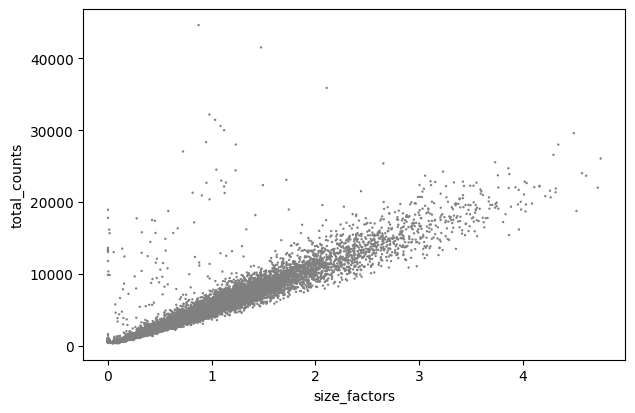

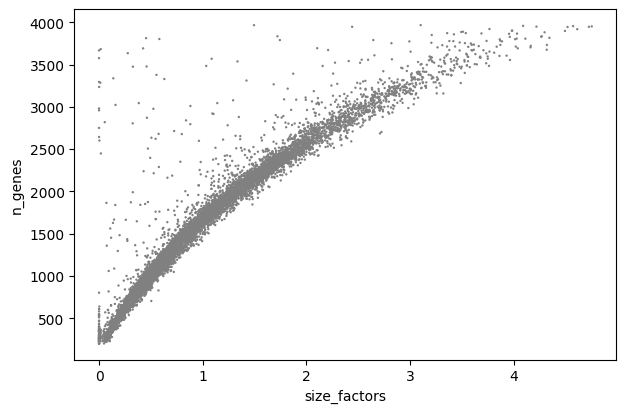

/var/folders/s5/3jq6kdq963b44s2lmrc_2fd40000gn/T/ipykernel_47621/1409471852.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(size_factors, bins=50, kde=False)


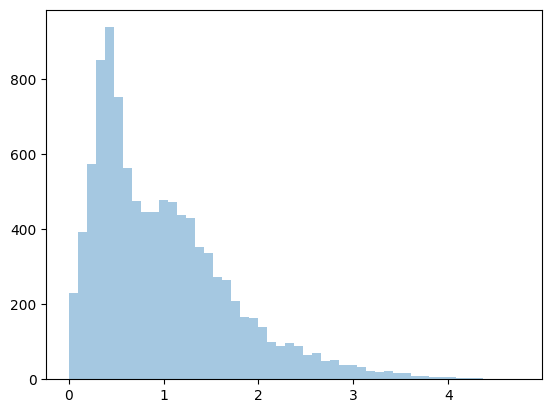

In [13]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'total_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [14]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [15]:
# high variable genes selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


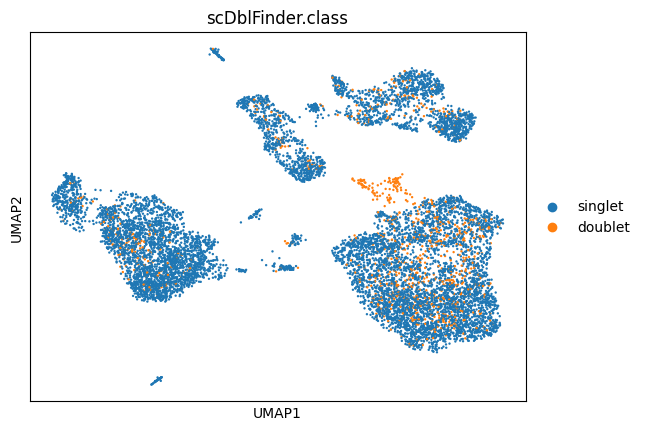

In [16]:
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)
sc.pl.umap(adata, color= ['scDblFinder.class'], save='_Alsaigh_sample1_doublet.png', ncols=1)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


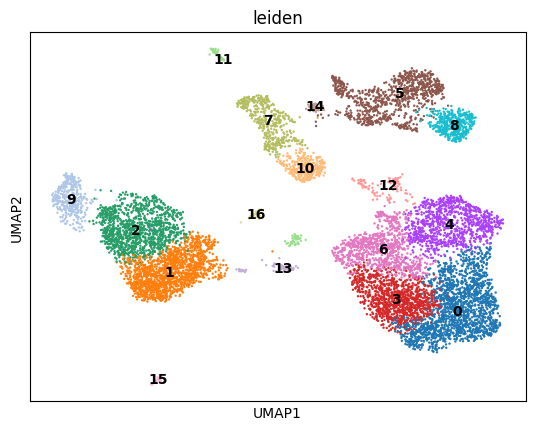

In [17]:
sc.pl.umap(adata, color= ['leiden'], save='_Alsaigh_sample1_leiden.png', ncols=1, legend_loc='on data')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


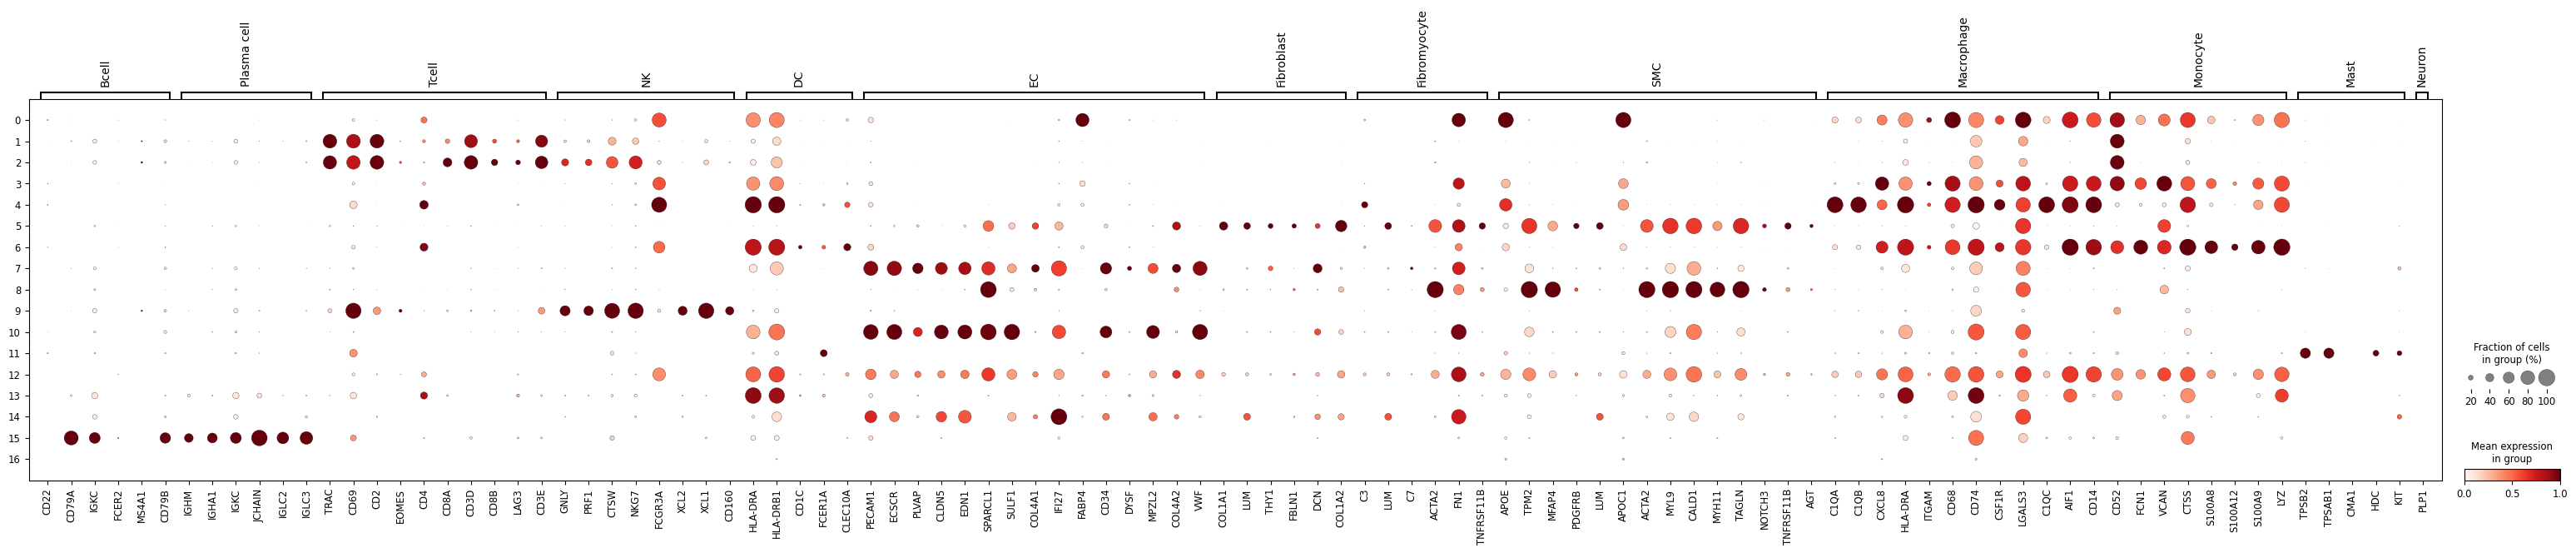

In [18]:
sc.pl.dotplot(
    adata,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="Alsaigh_sample1.png",
)

In [19]:
cluster_annotation1 = {
    "0": "Macrophage",
    "1": "T cell",
    "2": "T cell",
    "3": "Macrophage",
    "4": "Macrophage",
    "5": "SMC",
    "6": "Macrophage", #maybe monocytes
    "7": "EC",
    "8": "SMC",
    "9": "NK",
    "10": "EC",
    "11": "Mast cell",
    "12": "doublets", # REMOVE
    "13": "unknown",
    "14": "unknown",
    "15": "Plasma cell", # or Bcells (?)
    "16": "unknown"
}

In [20]:
adata.obs["cell_type_level1"] = adata.obs.leiden.map(cluster_annotation1)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


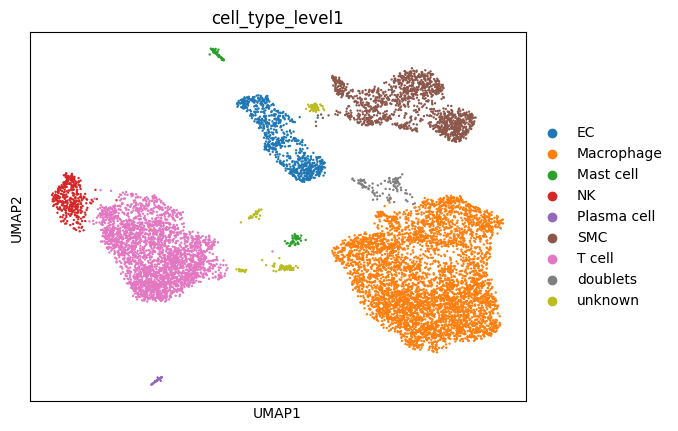

In [21]:
sc.pl.umap(adata, color= ['cell_type_level1'], save='_Alsaigh_sample1_annot.png', ncols=1)

In [37]:
#DONT delete all cells that have cell_type = doublets
#adata = adata[adata.obs["cell_type_level1"] != "doublets", :].copy()

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


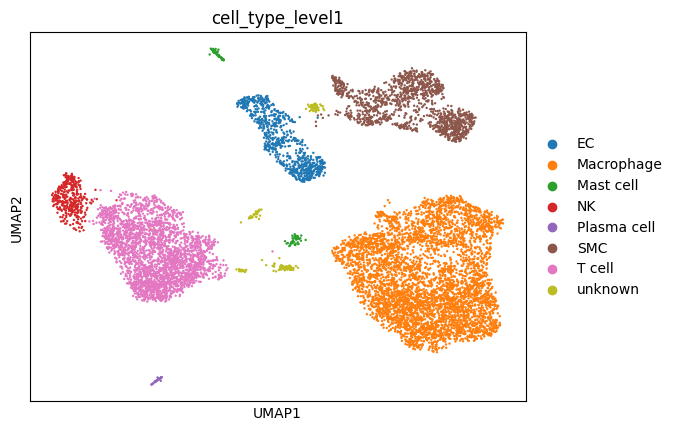

In [38]:
#only creates this plot when previous cell is used to remove doublets
sc.pl.umap(adata, color= ['cell_type_level1'], save='_Alsaigh_sample1_annot_nodoublets.png', ncols=1)

In [23]:
#adata.write_h5ad("Alsaigh_sample1_annot.h5ad") # doublets removed
adata.write_h5ad("../data/Plaque-datasets/Alsaigh/Alsaigh_sample1_annot_withdoublets.h5ad") # doublets not removed

In [24]:
#subcluster SMCs 
adata=sc.read_h5ad("../data/Plaque-datasets/Alsaigh/Alsaigh_sample1_annot_withdoublets.h5ad")
adata = adata[adata.obs["cell_type_level1"] == "SMC", :].copy()
sc.tl.leiden(adata, resolution = 0.2, key_added='leiden_subclustering')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


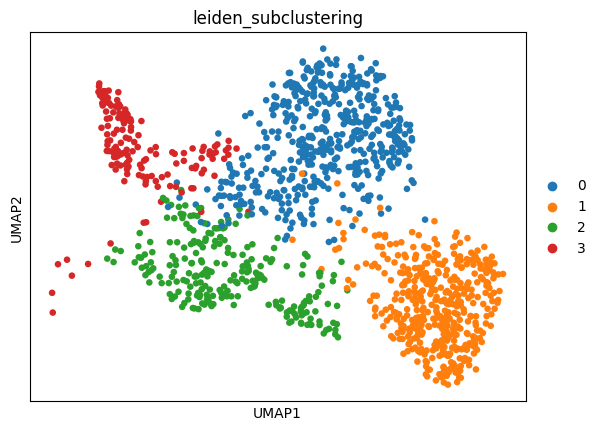

In [25]:
sc.pl.umap(adata, color= ['leiden_subclustering'], ncols=1, save='_Alsaigh_sample1_leiden_subclustering.png')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


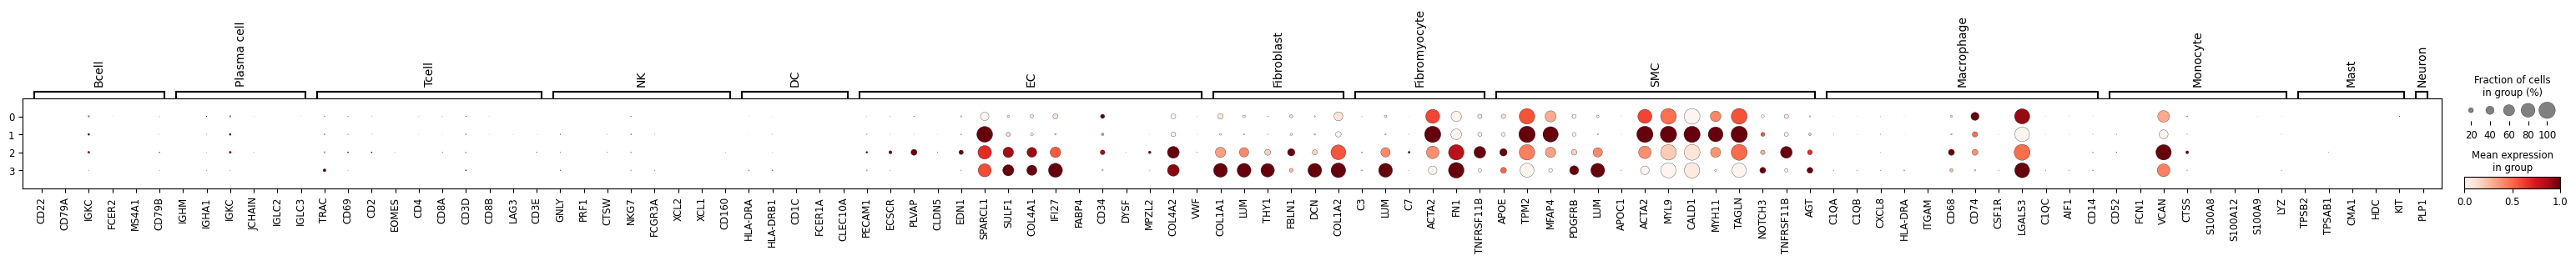

In [26]:
sc.pl.dotplot(
    adata,
    groupby="leiden_subclustering",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="Alsaigh_sample1_subclustering.png"
)

In [27]:
subclustering_annotation = {
    "0": "unknown",
    "1": "SMC", 
    "2": "Fibromyocyte",
    "3": "Fibroblast"
}

In [28]:
adata_sample1 = sc.read_h5ad("../data/Plaque-datasets/Alsaigh/Alsaigh_sample1_annot_withdoublets.h5ad")

In [29]:
#adata is the subclustered data and a new obs called leiden_subclustering. add this new column to the original adata_sample1
adata_sample1.obs["leiden_subclustering"] = adata.obs["leiden_subclustering"].copy()

In [30]:
# map subclustering_annotation to adata_sample1 cell_type_level1 and overwrite the previous cell_type_level1. If the leiden_subclustering is NA, then keep the previous cell_type_level1
adata_sample1.obs["cell_type_level1"] = adata_sample1.obs["leiden_subclustering"].map(subclustering_annotation).astype('object').fillna(adata_sample1.obs["cell_type_level1"].astype('object'))

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


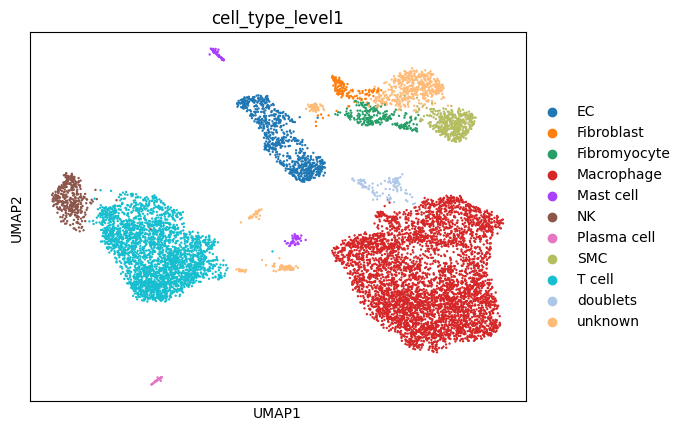

In [32]:
sc.pl.umap(adata_sample1, color= ['cell_type_level1'],ncols=1, save='_Alsaigh_sample1_annot_subclustering_withdoublets.png')

In [35]:
adata_sample1.write_h5ad('../data/Plaque-datasets/Alsaigh/Alsaigh_sample1_annot_subSMC_withdoublets.h5ad')

### Sample 2

In [7]:
adata = adata[adata.obs["sample"] == "2", :].copy() 

In [8]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/env

In [9]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [10]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.toarray()

In [11]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

Lade nötiges Paket: SingleCellExperiment
Lade nötiges Paket: SummarizedExperiment
Lade nötiges Paket: MatrixGenerics
Lade nötiges Paket: matrixStats

Attache Paket: ‘MatrixGenerics’

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQua

In [12]:
del adata_pp

In [14]:
adata.obs['size_factors'] = size_factors

In [15]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [16]:
# high variable genes selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


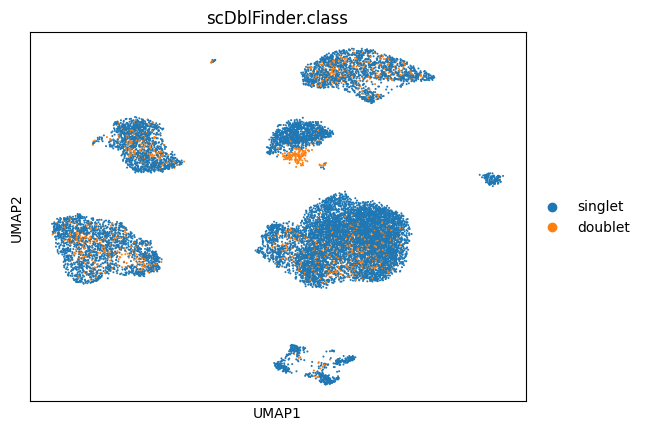

In [17]:
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)
sc.pl.umap(adata, color= ['scDblFinder.class'], save='_Alsaigh_sample2_doublet.png', ncols=1)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


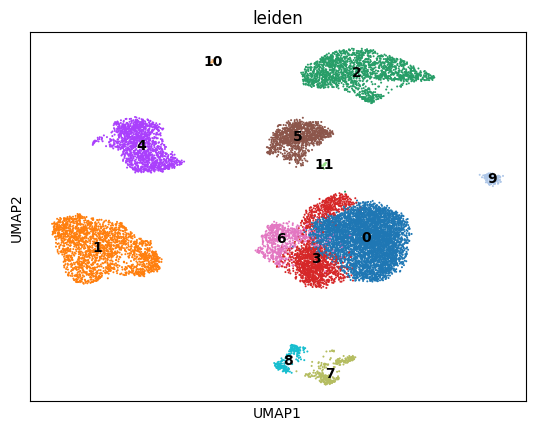

In [18]:
sc.pl.umap(adata, color= ['leiden'], save='_Alsaigh_sample2_leiden.png', ncols=1, legend_loc='on data')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


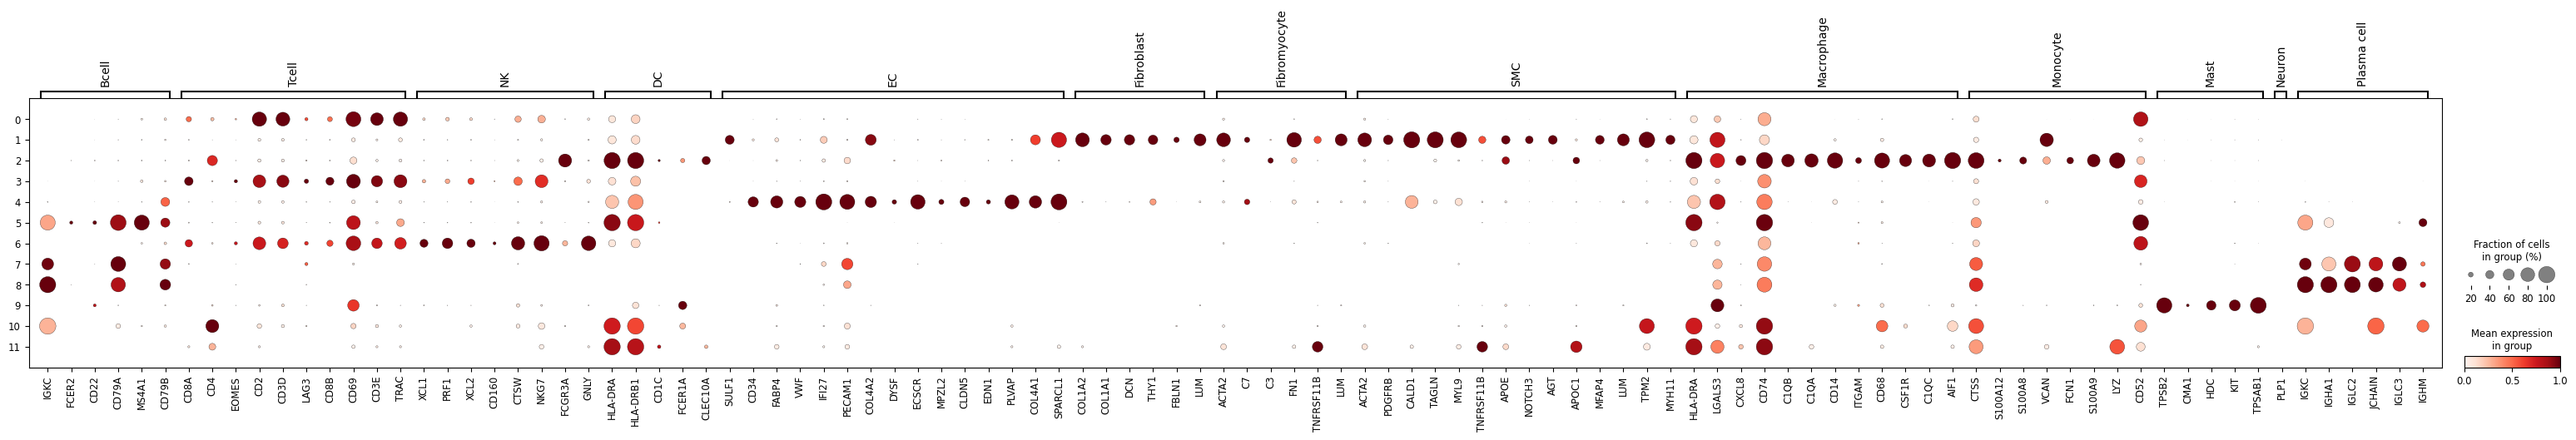

In [19]:
sc.pl.dotplot(
    adata,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="Alsaigh_sample2.png",
)

In [20]:
cluster_annotation2 = {
    "0": "T cell",
    "1": "SMC",
    "2": "Macrophage",
    "3": "T cell",
    "4": "EC",
    "5": "B cell",
    "6": "NK", 
    "7": "B cell",
    "8": "Plasma cell",
    "9": "Mast cell",
    "10": "unknown",
    "11": "unknown",
}

In [21]:
adata.obs["cell_type_level1"] = adata.obs.leiden.map(cluster_annotation2)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


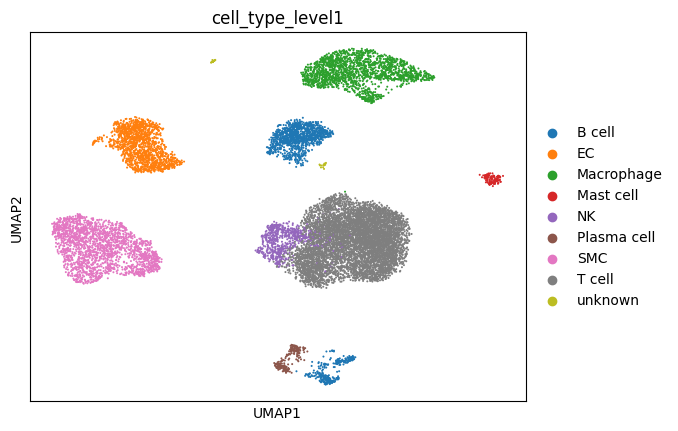

In [23]:
sc.pl.umap(adata, color= ['cell_type_level1'], save='_Alsaigh_sample2_annot.png', ncols=1)

In [24]:
adata.write_h5ad("Alsaigh_sample2_annot.h5ad")

In [47]:
#cluster 1 subclustering
adata = sc.read_h5ad("../data/Plaque-datasets/Alsaigh/Alsaigh_sample2_annot.h5ad")
adata = adata[adata.obs["leiden"] == "1", :].copy()
sc.tl.leiden(adata, resolution = 0.4, key_added='leiden_subclustering')


/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


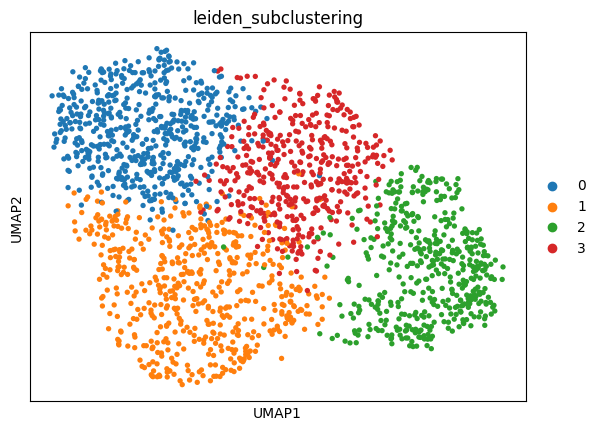

In [51]:
sc.pl.umap(adata, color= ['leiden_subclustering'], ncols=1, save='_Alsaigh_sample2_leiden_subclustering.png')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


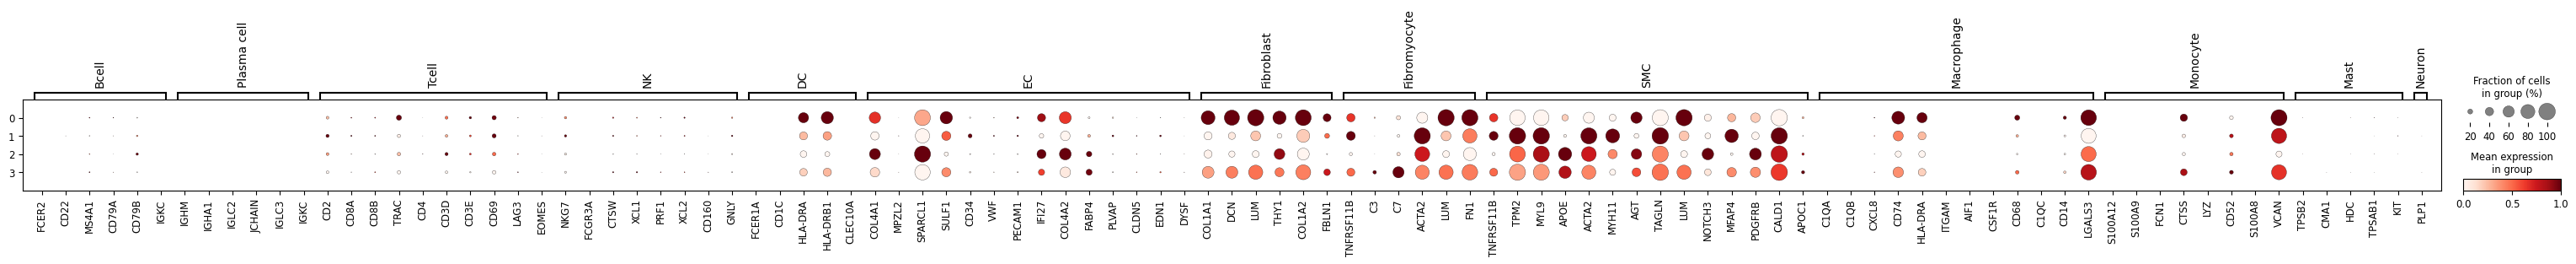

In [50]:
sc.pl.dotplot(
    adata,
    groupby="leiden_subclustering",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="Alsaigh_sample2_subclustering.png",
)

In [49]:
subclustering_annotation = {
    "0": "Fibroblast",
    "1": "unknown", #maybe Fibromyocyte
    "2": "SMC",
    "3": "SMC"
}

In [52]:
adata_sample2 = sc.read_h5ad("../data/Plaque-datasets/Alsaigh/Alsaigh_sample2_annot.h5ad")

In [54]:
#adata is the subclustered data and a new obs called leiden_subclustering. add this new column to the original adata_sample2 and fill the empty cells with "not subclustered"
adata_sample2.obs["leiden_subclustering"] = adata.obs["leiden_subclustering"].copy()


In [58]:
# map subclustering_annotation to adata_sample2 cell_type_level1 and overwrite the previous cell_type_level1. If the leiden_subclustering is NA, then keep the previous cell_type_level1
adata_sample2.obs["cell_type_level1"] = adata_sample2.obs.leiden_subclustering.map(subclustering_annotation).fillna(adata_sample2.obs["cell_type_level1"])

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


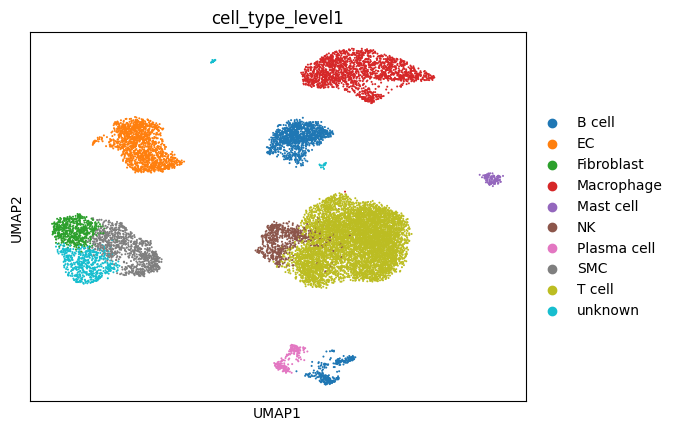

In [62]:
sc.pl.umap(adata_sample2, color= ['cell_type_level1'],ncols=1, save='_Alsaigh_sample2_annot_subclustering.png')

In [63]:
adata_sample2.write_h5ad("../data/Plaque-datasets/Alsaigh/Alsaigh_sample2_annot_sub1.h5ad")

### Sample 3

In [7]:
adata = adata[adata.obs["sample"] == "3", :].copy() 

In [8]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/env

In [9]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [10]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.toarray()

In [11]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

Lade nötiges Paket: SingleCellExperiment
Lade nötiges Paket: SummarizedExperiment
Lade nötiges Paket: MatrixGenerics
Lade nötiges Paket: matrixStats

Attache Paket: ‘MatrixGenerics’

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQua

In [12]:
del adata_pp

In [13]:
adata.obs['size_factors'] = size_factors

In [14]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [15]:
# high variable genes selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)

In [23]:
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.6)
sc.pl.umap(adata, color= ['scDblFinder.class'], save='_Alsaigh_sample3_doublet.png', ncols=1)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


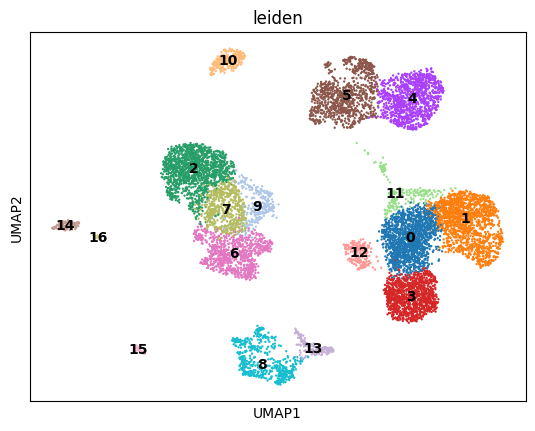

In [26]:
sc.pl.umap(adata, color= ['leiden'], save='_Alsaigh_sample3_leiden.png', ncols=1, legend_loc='on data')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


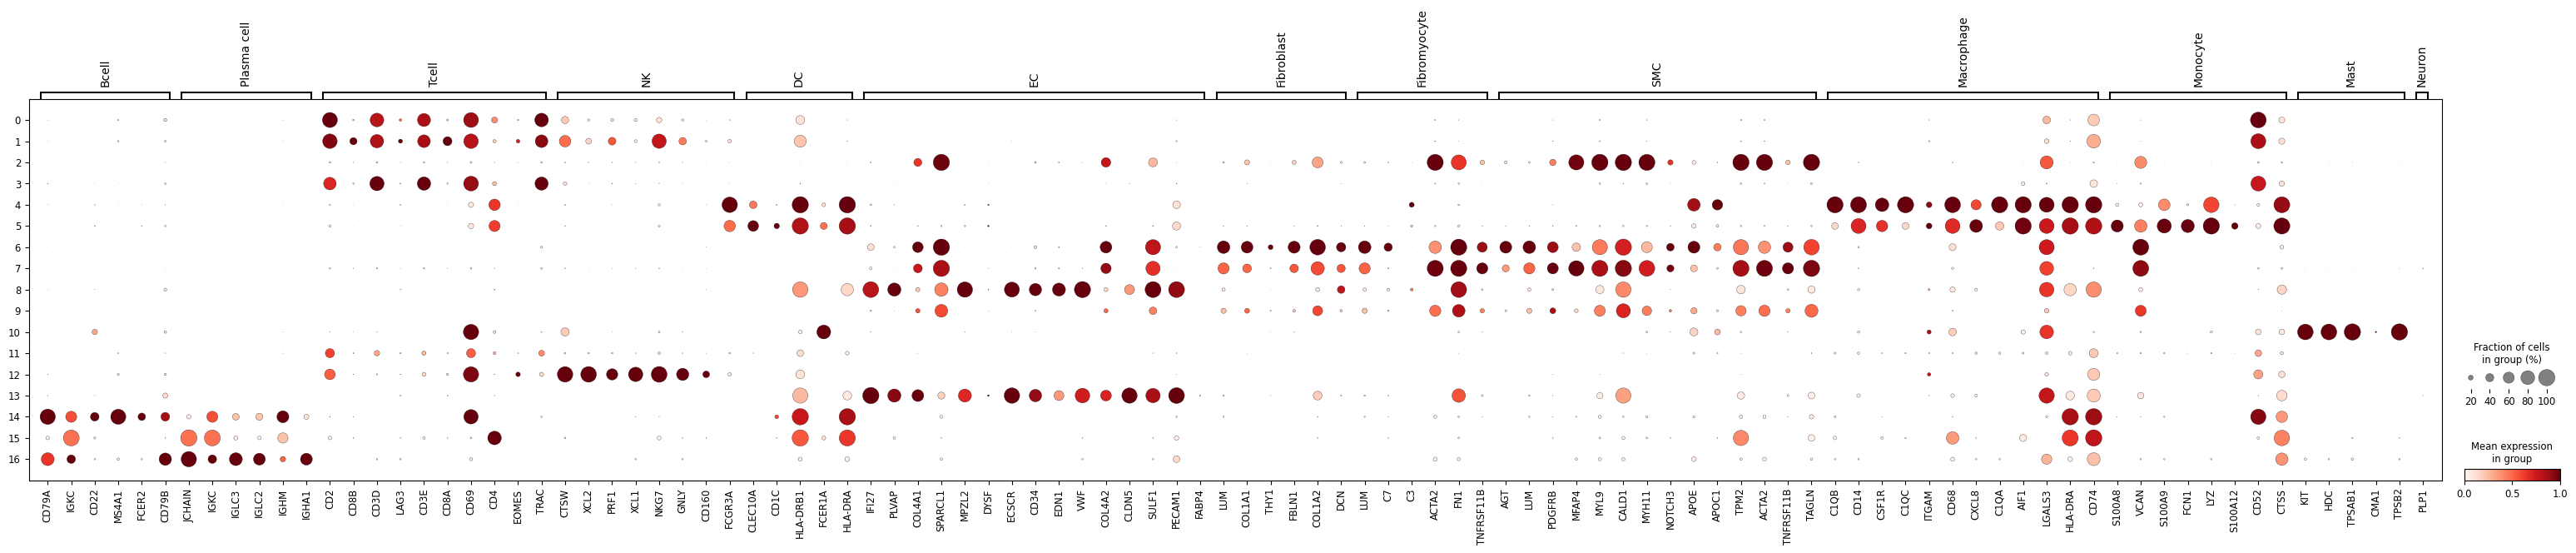

In [27]:
sc.pl.dotplot(
    adata,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="Alsaigh_sample3.png",
)

In [28]:
cluster_annotation3 = {
    "0": "T cell",
    "1": "T cell",
    "2": "SMC",
    "3": "T cell",
    "4": "Macrophage",
    "5": "Monocyte", # unsure if macrophage or monocyte or DC
    "6": "Fibroblast", 
    "7": "Fibromyocyte", # because strong FN1 and ACTA2
    "8": "EC",
    "9": "unknown",
    "10": "Mast cell",
    "11": "unknown",
    "12": "NK",
    "13": "EC",
    "14": "B cell",
    "15": "unknown",
    "16": "Plasma cell",
}

In [29]:
adata.obs["cell_type_level1"] = adata.obs.leiden.map(cluster_annotation3)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


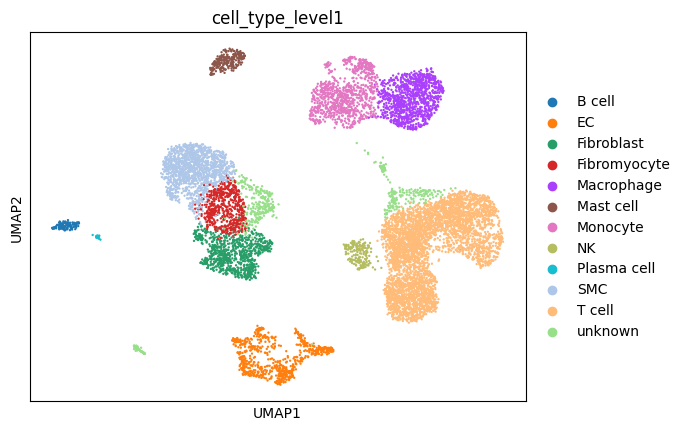

In [30]:
sc.pl.umap(adata, color= ['cell_type_level1'], save='_Alsaigh_sample3_annot1.png', ncols=1)

In [31]:
adata.write_h5ad("Alsaigh_sample3_annot.h5ad")

### Put annotated samples in one object

In [36]:
adata1 = sc.read_h5ad('../data/Plaque-datasets/Alsaigh/Alsaigh_sample1_annot_subSMC_withdoublets.h5ad')
adata2 = sc.read_h5ad('../data/Plaque-datasets/Alsaigh/Alsaigh_sample2_annot_sub1.h5ad')
adata3 = sc.read_h5ad('../data/Plaque-datasets/Alsaigh/Alsaigh_sample3_annot.h5ad')

In [37]:
adata1

AnnData object with n_obs × n_vars = 10272 × 22742
    obs: 'sample', 'dataset', 'symptoms', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'decontX_contamination', 'decontX_clusters', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'size_factors', 'leiden', 'cell_type_level1', 'leiden_subclustering'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'X_name', 'cell_type_level1_colors', 'decontX', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'scDblFinder.class_colors', 'scDblFinder.threshold', 'umap'
    obsm: 'X_pca', 'X_umap', 'decontX_1_UMAP', 'decontX_2_UMAP', 'decontX_3_UMAP'
    varm: 'PCs'
    layers: 'raw_decontXcounts', 'rounded_corrected_counts', 'uncorrected_counts'
    obsp: 'connectivities', 'distances'

In [38]:
adata2

AnnData object with n_obs × n_vars = 14157 × 22742
    obs: 'sample', 'dataset', 'symptoms', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'decontX_contamination', 'decontX_clusters', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'size_factors', 'leiden', 'cell_type_level1', 'leiden_subclustering'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'X_name', 'cell_type_level1_colors', 'decontX', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'scDblFinder.class_colors', 'scDblFinder.threshold', 'umap'
    obsm: 'X_pca', 'X_umap', 'decontX_1_UMAP', 'decontX_2_UMAP', 'decontX_3_UMAP'
    varm: 'PCs'
    layers: 'raw_decontXcounts', 'rounded_corrected_counts', 'uncorrected_counts'
    obsp: 'connectivities', 'distances'

In [39]:
adata3

AnnData object with n_obs × n_vars = 10556 × 22742
    obs: 'sample', 'dataset', 'symptoms', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'decontX_contamination', 'decontX_clusters', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'size_factors', 'leiden', 'cell_type_level1'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'X_name', 'cell_type_level1_colors', 'decontX', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'scDblFinder.class_colors', 'scDblFinder.threshold', 'umap'
    obsm: 'X_pca', 'X_umap', 'decontX_1_UMAP', 'decontX_2_UMAP', 'decontX_3_UMAP'
    varm: 'PCs'
    layers: 'raw_decontXcounts', 'rounded_corrected_counts', 'uncorrected_counts'
    obsp: 'connectivities', 'distances'

In [40]:
adata_list = [adata1, adata2, adata3]

In [41]:
adata_final = anndata.concat(adata_list, join='outer', fill_value=0.0)

In [42]:
adata_final

AnnData object with n_obs × n_vars = 34985 × 22742
    obs: 'sample', 'dataset', 'symptoms', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'decontX_contamination', 'decontX_clusters', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'size_factors', 'leiden', 'cell_type_level1', 'leiden_subclustering'
    obsm: 'X_pca', 'X_umap', 'decontX_1_UMAP', 'decontX_2_UMAP', 'decontX_3_UMAP'
    layers: 'raw_decontXcounts', 'rounded_corrected_counts', 'uncorrected_counts'

In [43]:
adata_final.write_h5ad("../data/Plaque-datasets/Alsaigh/Alsaigh_annot_all_withsubclusters_withdoublets.h5ad")

In [41]:
# high variable genes selection
sc.pp.highly_variable_genes(adata_final, n_top_genes=2000, subset=False)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/env

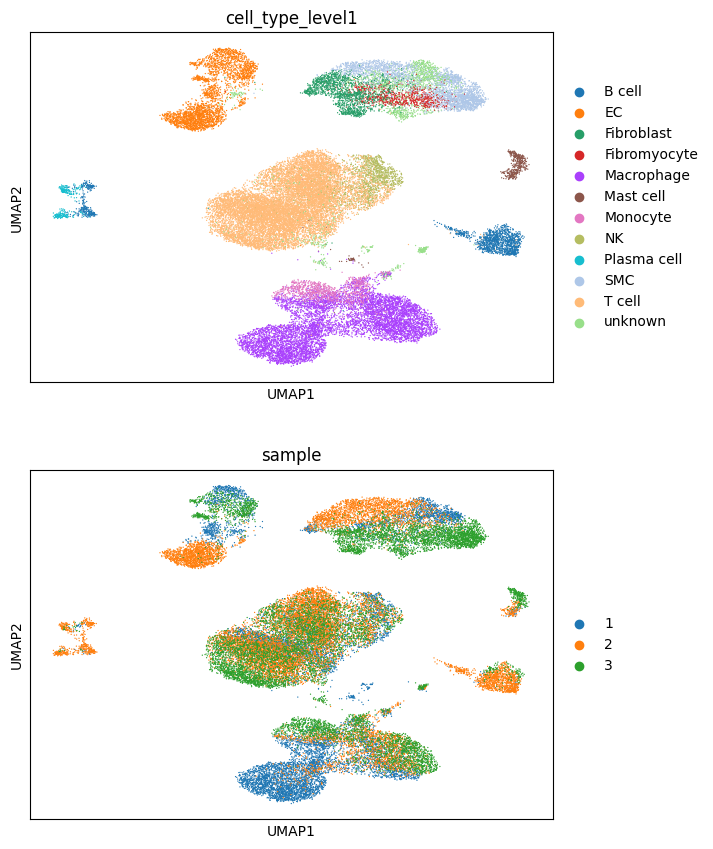

In [42]:
sc.pp.pca(adata_final, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata_final, n_pcs=30)
sc.tl.umap(adata_final)
sc.pl.umap(adata_final, color= ['cell_type_level1', 'sample'], ncols=1)

In [43]:
adata_final.write_h5ad("Alsaigh_annot_all_withsubclusters.h5ad")

# Wirka

In [4]:
adata = sc.read_h5ad("../data/Plaque-datasets/Wirka/Wirka_postQC.h5ad")

In [5]:
adata.layers['rounded_corrected_counts'] = adata.X.copy()

In [6]:
#check how many cells have zero counts for all genes
cellwise_sum = adata.X.sum(axis=1)
num_cells_zero_counts = (cellwise_sum == 0).sum()
#remove cells with zero counts for all genes
adata = adata[cellwise_sum != 0].copy()
print(num_cells_zero_counts)

0


In [7]:
adata.obs['sample'].value_counts()

sample
6    2385
7    2089
5    1847
8    1752
3    1491
4    1400
1     530
2     262
Name: count, dtype: int64

In [7]:
adata

AnnData object with n_obs × n_vars = 11756 × 20431
    obs: 'cell_type', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'decontX_contamination', 'decontX_clusters', 'symptoms'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'X_name', 'decontX', 'scDblFinder.threshold'
    obsm: 'decontX_1_UMAP', 'decontX_2_UMAP', 'decontX_3_UMAP', 'decontX_4_UMAP', 'decontX_5_UMAP', 'decontX_6_UMAP', 'decontX_7_UMAP', 'decontX_8_UMAP'
    layers: 'raw_decontXcounts', 'uncorrected_counts', 'rounded_corrected_counts'

In [8]:
#check if the marker genes are in the data and print percentage of marker genes per celltype in the data
#also print which marker genes are not in the data
#create new dict on the way
marker_genes_in_data = {}
for celltype in level1_marker:
    marker_genes_in_data[celltype] = list(set(level1_marker[celltype]).intersection(adata.var_names))
    print(celltype, len(set(level1_marker[celltype]).intersection(adata.var_names))/len(level1_marker[celltype]))
    print("not included: ", set(level1_marker[celltype]).difference(adata.var_names))

Bcell 1.0
not included:  set()
Plasma cell 1.0
not included:  set()
Tcell 1.0
not included:  set()
NK 1.0
not included:  set()
DC 1.0
not included:  set()
EC 0.9333333333333333
not included:  {'ECSCR'}
Fibroblast 1.0
not included:  set()
Fibromyocyte 1.0
not included:  set()
SMC 1.0
not included:  set()
Macrophage 1.0
not included:  set()
Monocyte 1.0
not included:  set()
Mast 1.0
not included:  set()
Neuron 1.0
not included:  set()


### Sample 6

In [11]:
adata = adata[adata.obs["sample"] == "6", :].copy() 

In [12]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/env

In [13]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [14]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.toarray()

In [15]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

Lade nötiges Paket: SingleCellExperiment
Lade nötiges Paket: SummarizedExperiment
Lade nötiges Paket: MatrixGenerics
Lade nötiges Paket: matrixStats

Attache Paket: ‘MatrixGenerics’

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQua

In [16]:
del adata_pp

In [18]:
adata

AnnData object with n_obs × n_vars = 2385 × 20431
    obs: 'cell_type', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'decontX_contamination', 'decontX_clusters', 'symptoms', 'size_factors'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'X_name', 'decontX', 'scDblFinder.threshold'
    obsm: 'decontX_1_UMAP', 'decontX_2_UMAP', 'decontX_3_UMAP', 'decontX_4_UMAP', 'decontX_5_UMAP', 'decontX_6_UMAP', 'decontX_7_UMAP', 'decontX_8_UMAP'
    layers: 'raw_decontXcounts', 'uncorrected_counts', 'rounded_corrected_counts'

In [19]:
sc.pp.filter_cells(adata, min_genes=0) # to get n_genes

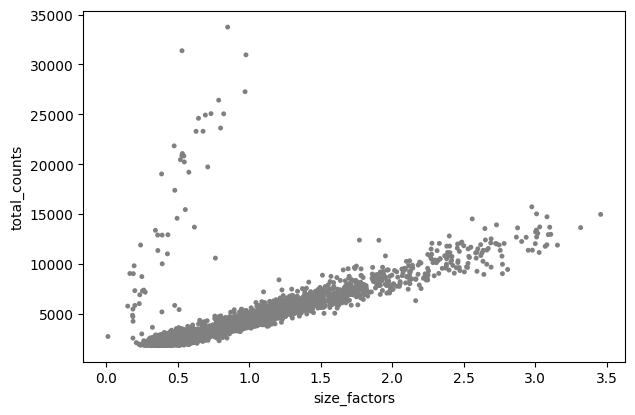

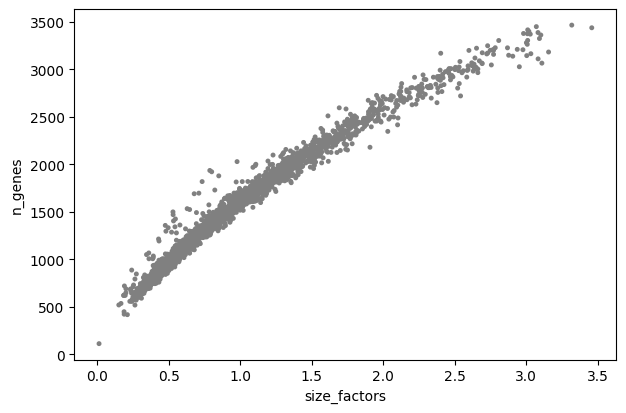

/var/folders/s5/3jq6kdq963b44s2lmrc_2fd40000gn/T/ipykernel_87446/1409471852.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(size_factors, bins=50, kde=False)


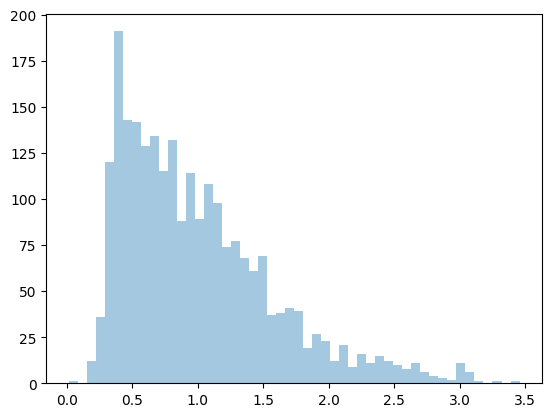

In [20]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'total_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [21]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [22]:
# high variable genes selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


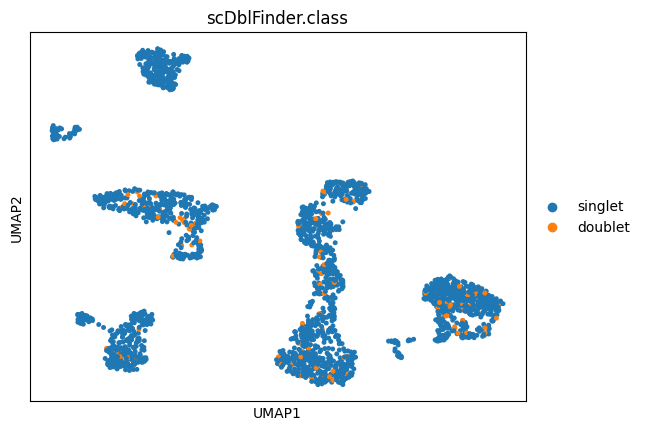

In [24]:
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)
sc.pl.umap(adata, color= ['scDblFinder.class'], ncols=1, save='_Wirka_sample6_doublet.png')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


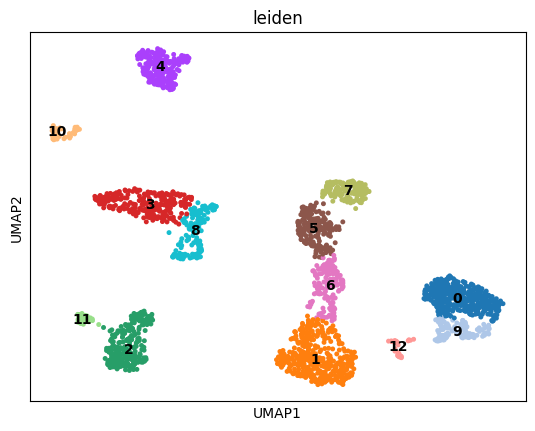

In [25]:
sc.pl.umap(adata, color= ['leiden'], save='_Wirka_sample6_leiden.png', ncols=1, legend_loc='on data')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


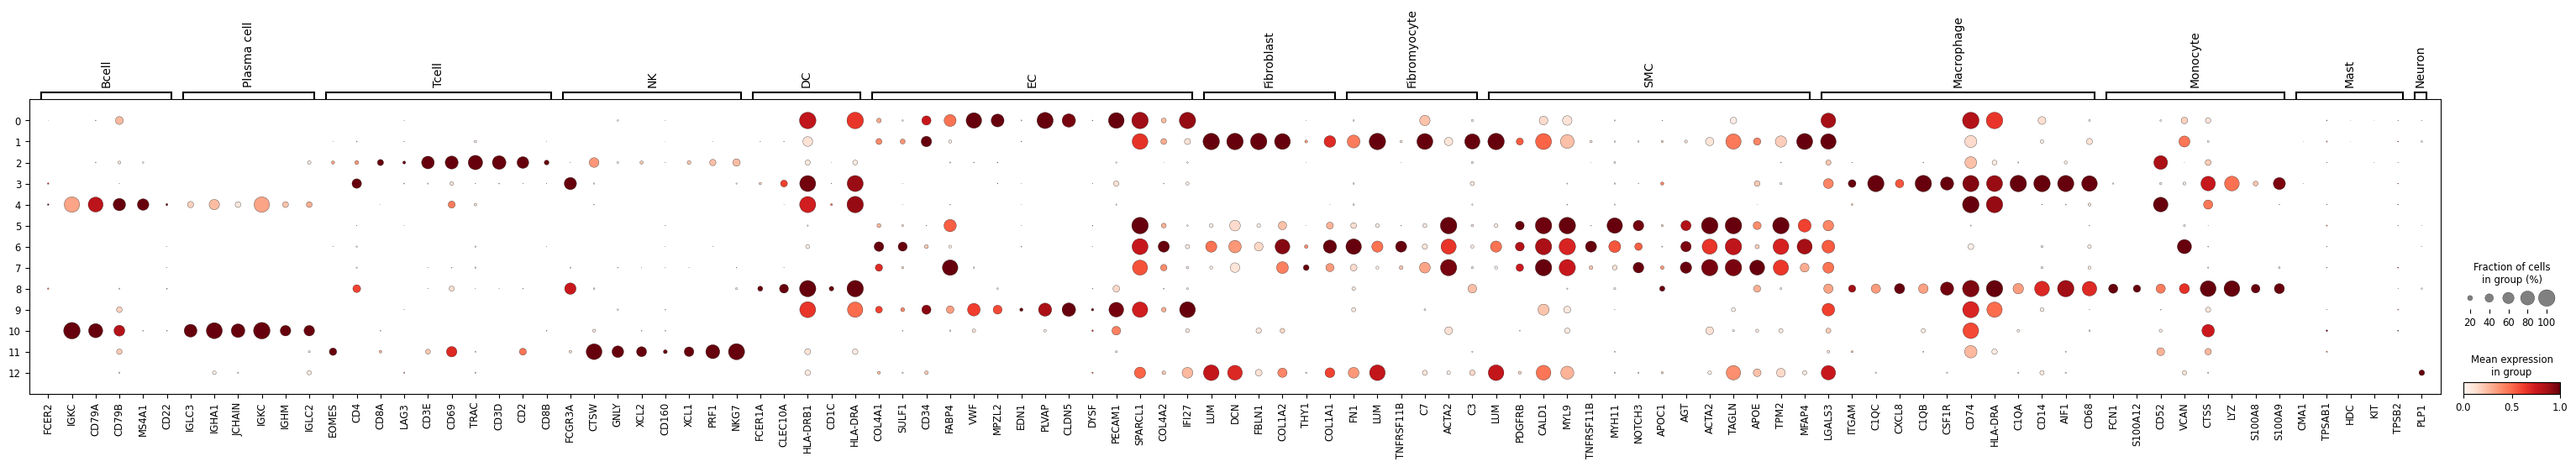

In [26]:
sc.pl.dotplot(
    adata,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="Wirka_sample6.png",
)

In [27]:
cluster_annotation6 = {
    "0": "EC",
    "1": "Fibroblast",
    "2": "T cell",
    "3": "Macrophage",
    "4": "B cell",
    "5": "SMC",
    "6": "Fibromyocyte", #unsure, could also be SMC. selected fibromyocyte because of FN1
    "7": "SMC",
    "8": "unknown", #could be DC or Macro or Monocyte
    "9": "EC",
    "10": "Plasma cell",
    "11": "NK",
    "12": "unknown"
}

In [28]:
adata.obs["cell_type_level1"] = adata.obs.leiden.map(cluster_annotation6)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


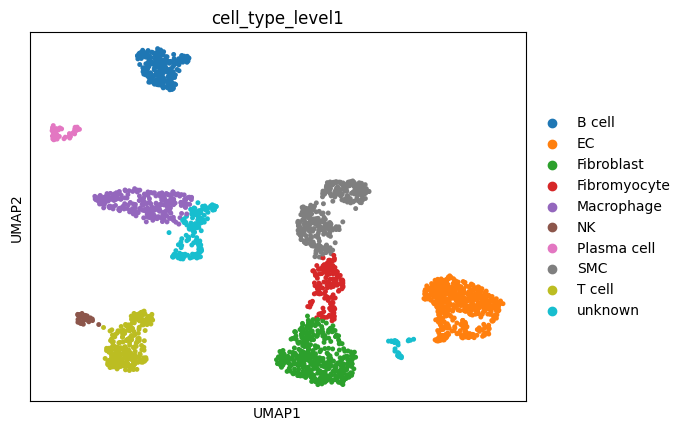

In [29]:
sc.pl.umap(adata, color= ['cell_type_level1'], save='_Wirka_sample6_annot.png', ncols=1)

In [30]:
adata.write_h5ad("../data/Plaque-datasets/Wirka/Wirka_sample6_annot.h5ad")

### Sample 7

In [8]:
adata = adata[adata.obs["sample"] == "7", :].copy() 

In [9]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/env

In [10]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [11]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.toarray()

In [12]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

Lade nötiges Paket: SingleCellExperiment
Lade nötiges Paket: SummarizedExperiment
Lade nötiges Paket: MatrixGenerics
Lade nötiges Paket: matrixStats

Attache Paket: ‘MatrixGenerics’

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQua

In [13]:
del adata_pp

In [14]:
adata.obs['size_factors'] = size_factors

In [15]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [16]:
# high variable genes selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


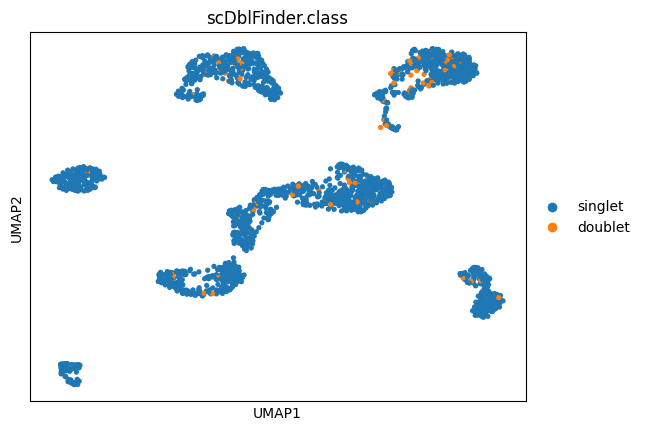

In [24]:
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.8)
sc.pl.umap(adata, color= ['scDblFinder.class'], ncols=1, save='_Wirka_sample7_doublet.png')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


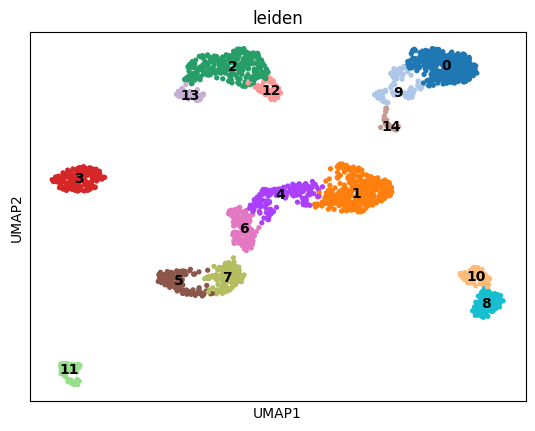

In [25]:
sc.pl.umap(adata, color= ['leiden'], save='_Wirka_sample7_leiden.png', ncols=1, legend_loc='on data')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


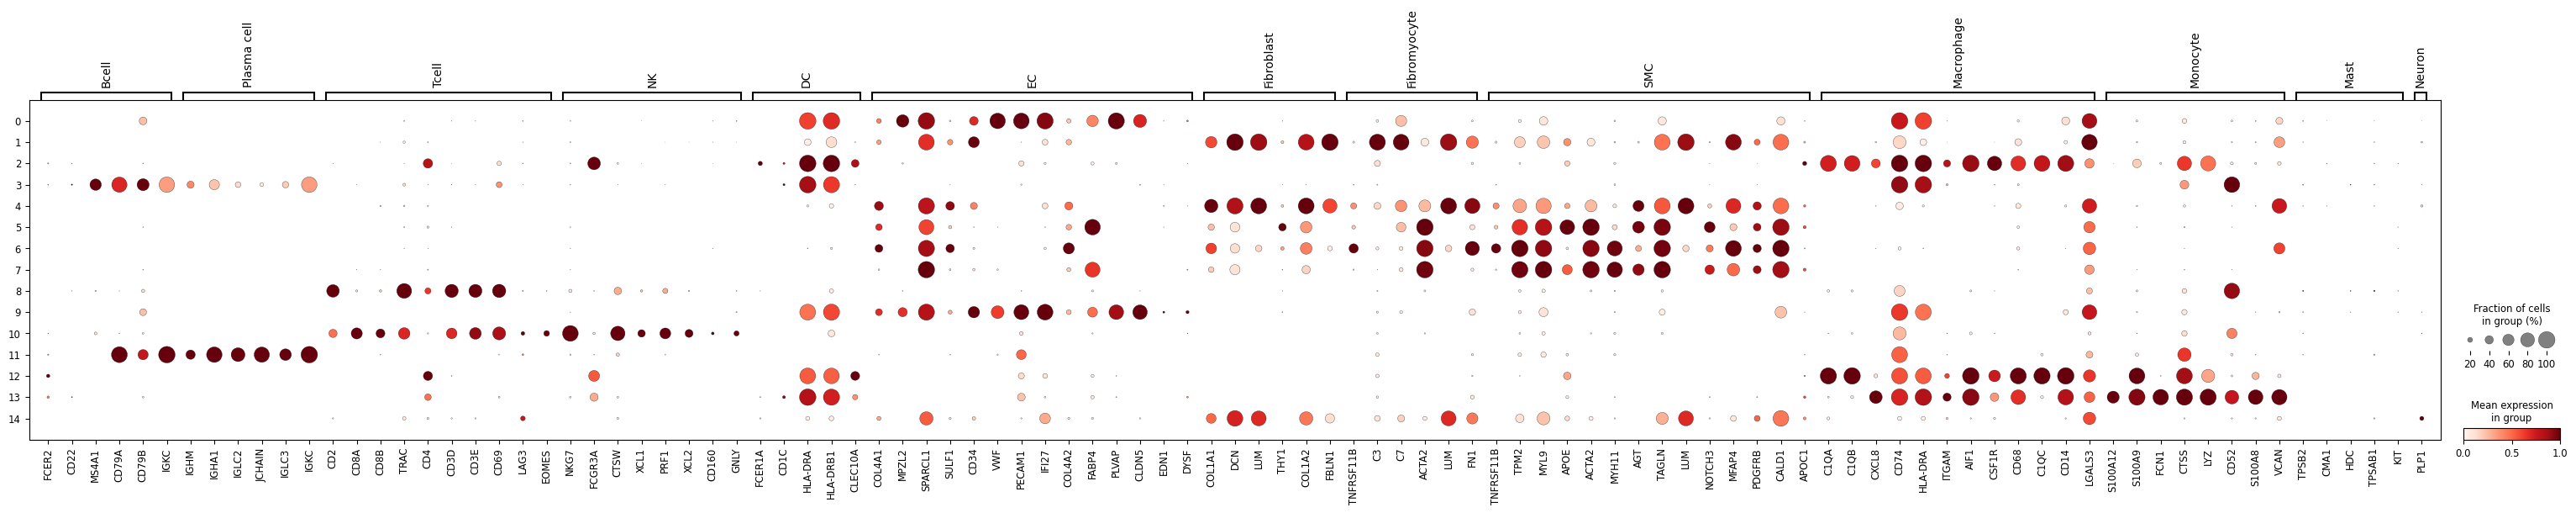

In [26]:
sc.pl.dotplot(
    adata,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="Wirka_sample7.png",
)

In [27]:
cluster_annotation7 = {
    "0": "EC",
    "1": "Fibroblast", #because low expression of ACTA2
    "2": "Macrophage",
    "3": "B cell",
    "4": "Fibromyocyte", #because high FN1 and some ACTA2
    "5": "SMC",
    "6": "SMC",
    "7": "SMC",
    "8": "T cell", 
    "9": "EC",
    "10": "NK",
    "11": "Plasma cell",
    "12": "Macrophage",
    "13": "Monocyte",
    "14": "unknown"
}

In [29]:
adata.obs["cell_type_level1"] = adata.obs.leiden.map(cluster_annotation7)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


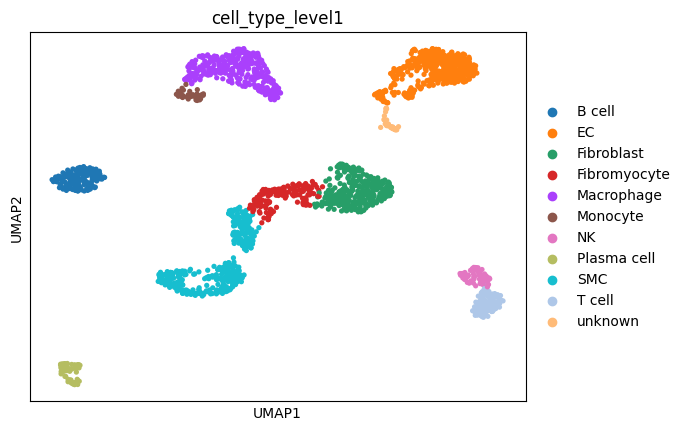

In [30]:
sc.pl.umap(adata, color= ['cell_type_level1'], save='_Wirka_sample7_annot.png', ncols=1)

In [31]:
adata.write_h5ad("../data/Plaque-datasets/Wirka/Wirka_sample7_annot.h5ad")

### Sample 5

In [19]:
adata = adata[adata.obs["sample"] == "5", :].copy() 

In [20]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

In [21]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.toarray()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [22]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

Lade nötiges Paket: SingleCellExperiment
Lade nötiges Paket: SummarizedExperiment
Lade nötiges Paket: MatrixGenerics
Lade nötiges Paket: matrixStats

Attache Paket: ‘MatrixGenerics’

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQua

In [23]:
del adata_pp

adata.obs['size_factors'] = size_factors

#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [24]:
# high variable genes selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


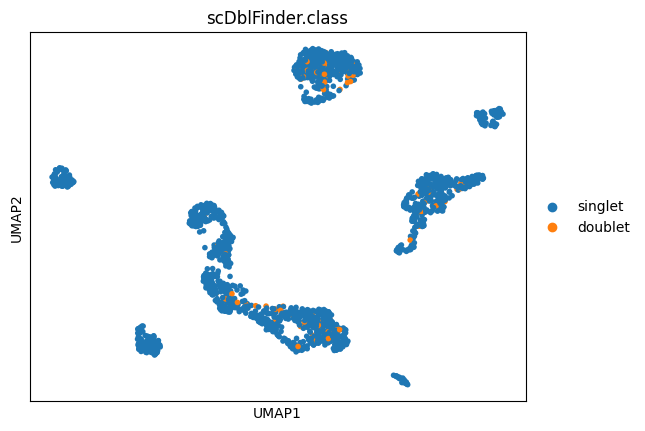

In [25]:
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)
sc.pl.umap(adata, color= ['scDblFinder.class'], ncols=1, save='_Wirka_sample5_doublet.png')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


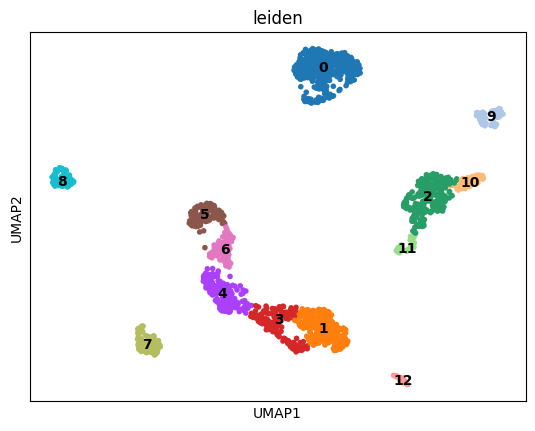

In [26]:
sc.pl.umap(adata, color= ['leiden'], save='_Wirka_sample5_leiden.png', ncols=1, legend_loc='on data')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


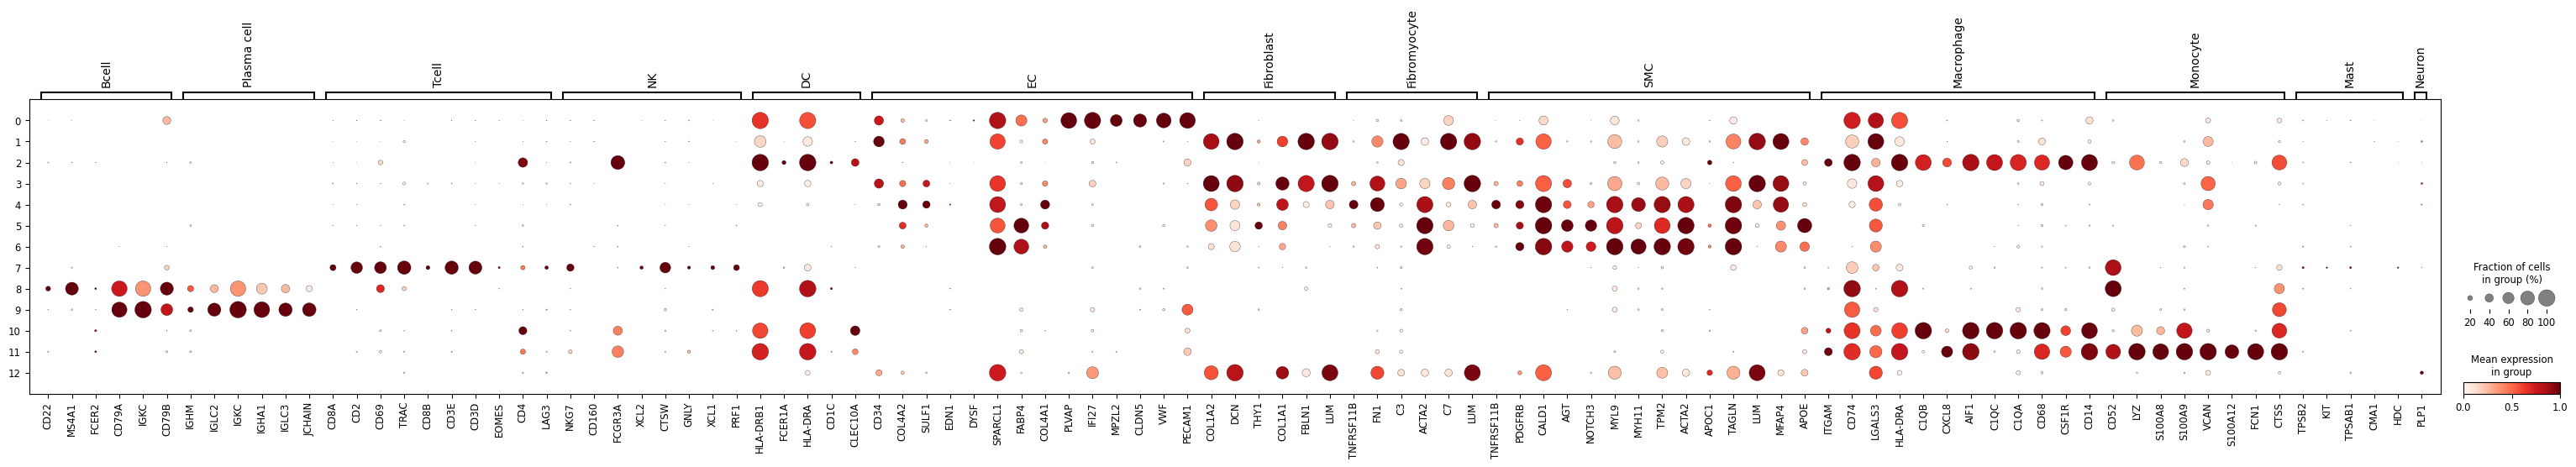

In [27]:
sc.pl.dotplot(
    adata,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="Wirka_sample5.png",
)

In [28]:
cluster_annotation5 = {
    "0": "EC",
    "1": "Fibroblast",
    "2": "Macrophage",
    "3": "Fibroblast",
    "4": "Fibromyocyte",
    "5": "SMC",
    "6": "SMC", 
    "7": "T cell",
    "8": "B cell", 
    "9": "Plasma cell",
    "10": "Macrophage",
    "11": "Monocyte",
    "12": "unknown"
}

In [29]:
adata.obs["cell_type_level1"] = adata.obs.leiden.map(cluster_annotation5)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


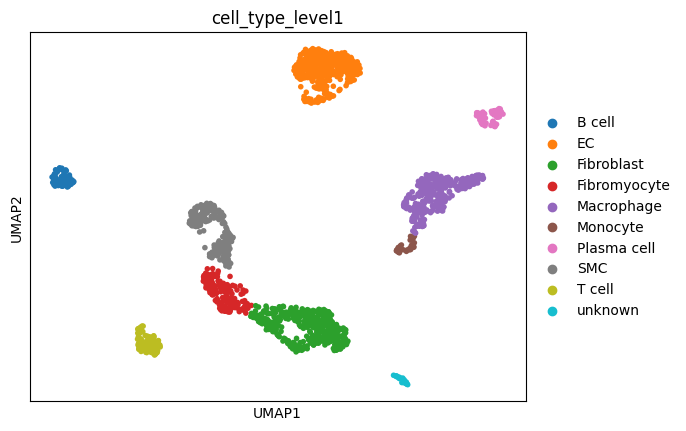

In [30]:
sc.pl.umap(adata, color= ['cell_type_level1'], save='_Wirka_sample5_annot.png', ncols=1)

In [31]:
adata.write_h5ad("../data/Plaque-datasets/Wirka/Wirka_sample5_annot.h5ad")

### Sample 8

In [9]:
adata = adata[adata.obs["sample"] == "8", :].copy() 

#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.toarray()

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/env

In [10]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

Lade nötiges Paket: SingleCellExperiment
Lade nötiges Paket: SummarizedExperiment
Lade nötiges Paket: MatrixGenerics
Lade nötiges Paket: matrixStats

Attache Paket: ‘MatrixGenerics’

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQua

In [11]:
del adata_pp

adata.obs['size_factors'] = size_factors

#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

# high variable genes selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


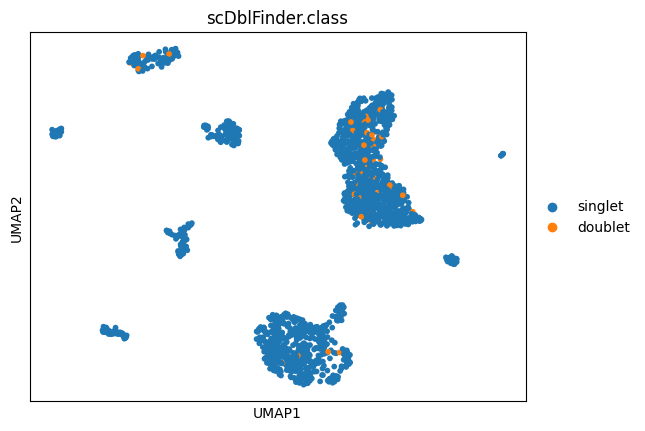

In [25]:
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 1)
sc.pl.umap(adata, color= ['scDblFinder.class'], ncols=1, save='_Wirka_sample8_doublet.png')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


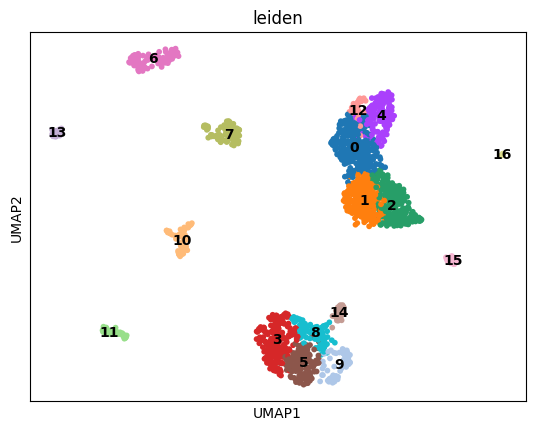

In [26]:
sc.pl.umap(adata, color= ['leiden'], save='_Wirka_sample8_leiden.png', ncols=1, legend_loc='on data')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


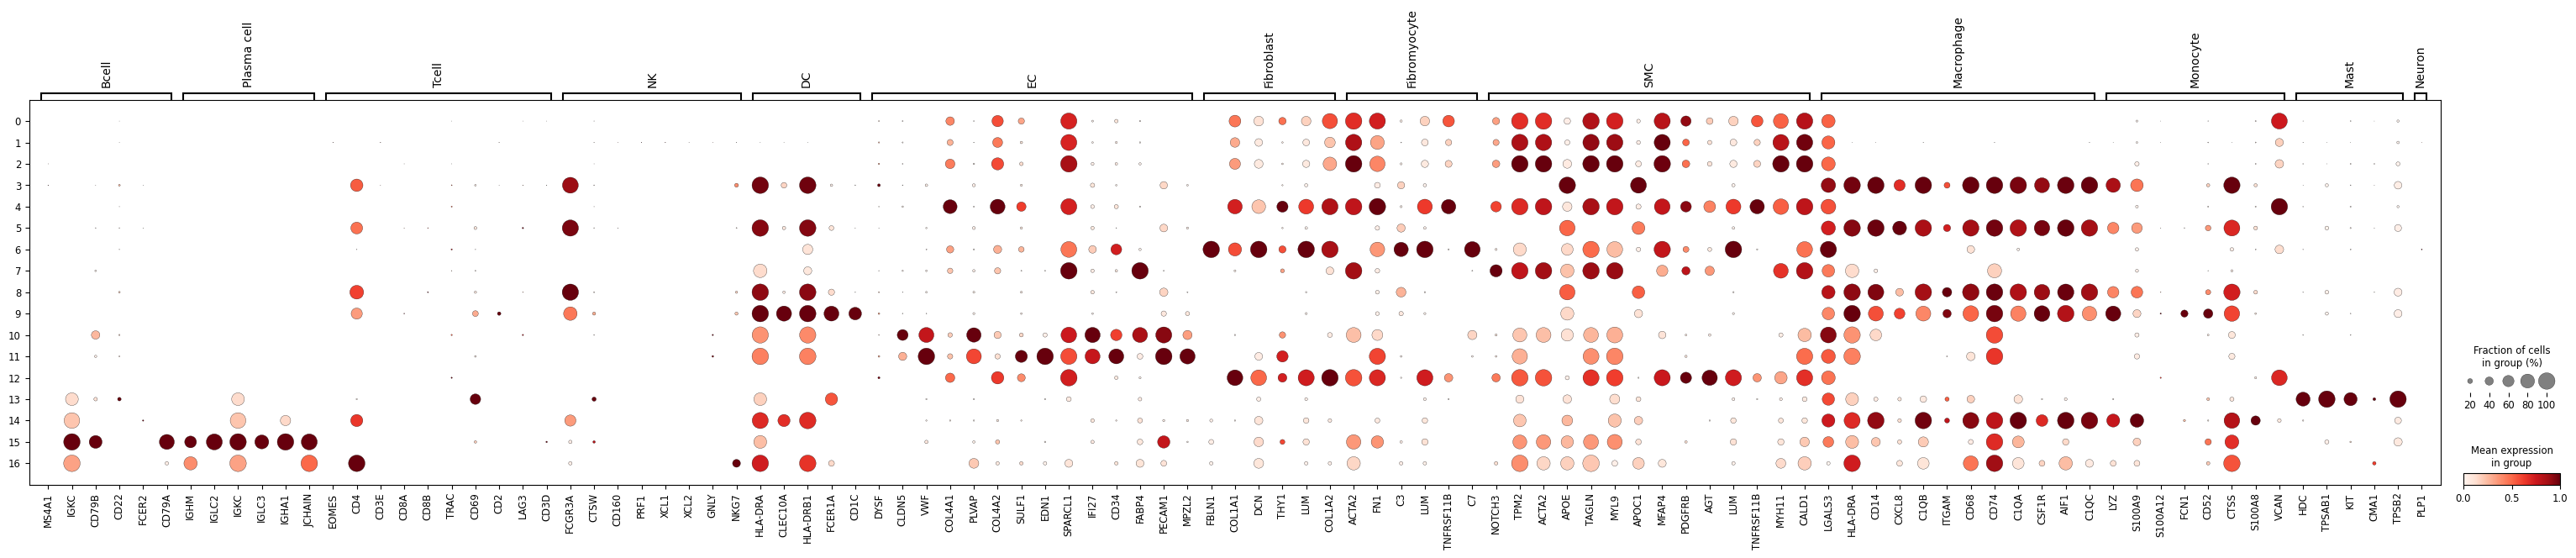

In [27]:
sc.pl.dotplot(
    adata,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="Wirka_sample8.png",
)

In [28]:
cluster_annotation8 = {
    "0": "unknown",
    "1": "unknown",
    "2": "SMC",
    "3": "Macrophage",
    "4": "unknown",
    "5": "Macrophage",
    "6": "unknown", #fibroblast markers but far away from SMC cluster 
    "7": "unknown",
    "8": "Macrophage", 
    "9": "DC",
    "10": "EC",
    "11": "EC",
    "12": "unknown",
    "13": "Mast",
    "14": "Macrophage",
    "15": "Plasma cell",
    "16": "unknown"
}

In [29]:
adata.obs["cell_type_level1"] = adata.obs.leiden.map(cluster_annotation8)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


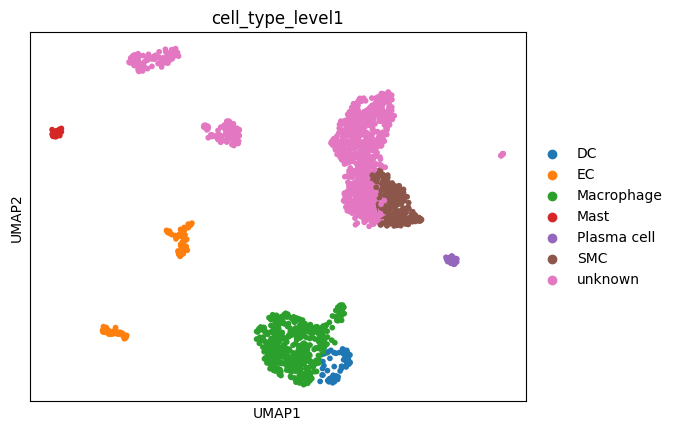

In [30]:
sc.pl.umap(adata, color= ['cell_type_level1'], save='_Wirka_sample8_annot.png', ncols=1)

In [31]:
adata.write_h5ad("../data/Plaque-datasets/Wirka/Wirka_sample8_annot.h5ad")

### concat

In [2]:
adata1 = sc.read_h5ad('../data/Plaque-datasets/Wirka/Wirka_sample6_annot.h5ad')
adata2 = sc.read_h5ad('../data/Plaque-datasets/Wirka/Wirka_sample7_annot.h5ad')
adata3 = sc.read_h5ad('../data/Plaque-datasets/Wirka/Wirka_sample5_annot.h5ad')
adata4 = sc.read_h5ad('../data/Plaque-datasets/Wirka/Wirka_sample8_annot.h5ad')

In [7]:
adata_list = [adata1, adata2, adata3, adata4]

In [8]:
adata_final = anndata.concat(adata_list, join='outer', fill_value=0.0)

In [10]:
adata_final.obs

cell_type sample  n_genes_by_counts  total_counts  \
AAACCTGAGCGTAGTG-6    Pericyte A      6             1551.0        3713.0   
AAACCTGAGCTGCAAG-6          Mono      6             1129.0        3317.0   
AAACCTGAGGACATTA-6         CD4 T      6             1082.0        2744.0   
AAACCTGAGGCTCATT-6            EC      6             1721.0        5098.0   
AAACCTGCAAGTAATG-6            EC      6             1749.0        5164.0   
...                          ...    ...                ...           ...   
TTTGGTTCAATTGCTG-8      TREM2 MΦ      8             1653.0        5122.0   
TTTGGTTTCTCTGTCG-8  Fibromyocyte      8             3489.0       14513.0   
TTTGTCACAAAGTGCG-8  Fibromyocyte      8             2615.0        9018.0   
TTTGTCACAGGACCCT-8  Fibromyocyte      8             2084.0        6162.0   
TTTGTCAGTCACCTAA-8        Inf MΦ      8             1234.0        3581.0   

                    total_counts_mt  pct_counts_mt dataset scDblFinder.sample  \
AAACCTGAGCGTAGTG-6             37.0       0.996499   Wirka                  6   
AAACCTGAGCTGCAAG-6             99.0       2.984625   Wirka                  6   
AAACCTGAGGACATTA-6             70.0       2.551020   Wirka                  6   
AAACCTGAGGCTCATT-6            129.0       2.530404   Wirka                  6   
AAACCTGCAAGTAATG-6            135.0       2.614253   Wirka                  6   
...                             ...            ...     ...                ...   
TTTGGTTCAATTGCTG-8             67.0       1.308083   Wirka                  8   
TTTGGTTTCTCTGTCG-8            178.0       1.226487   Wirka                  8   
TTTGTCACAAAGTGCG-8            171.0       1.896208   Wirka                  8   
TTTGTCACAGGACCCT-8             96.0       1.557936   Wirka                  8   
TTTGTCAGTCACCTAA-8             58.0       1.619659   Wirka                  8   

                   scDblFinder.class  scDblFinder.score  scDblFinder.weighted  \
AAACCTGAGCGTAGTG-6           singlet           0.000654              0.200135   
AAACCTGAGCTGCAAG-6           singlet           0.041145              0.364038   
AAACCTGAGGACATTA-6           singlet           0.003152              0.210620   
AAACCTGAGGCTCATT-6           singlet           0.001286              0.263461   
AAACCTGCAAGTAATG-6           singlet           0.124769              0.372537   
...                              ...                ...                   ...   
TTTGGTTCAATTGCTG-8           singlet           0.012560              0.426861   
TTTGGTTTCTCTGTCG-8           singlet           0.057232              0.549357   
TTTGTCACAAAGTGCG-8           doublet           0.943856              0.865522   
TTTGTCACAGGACCCT-8           singlet           0.020461              0.181819   
TTTGTCAGTCACCTAA-8           singlet           0.001821              0.061033   

                    scDblFinder.cxds_score  decontX_contamination  \
AAACCTGAGCGTAGTG-6                0.003861               0.019479   
AAACCTGAGCTGCAAG-6                0.032764               0.027448   
AAACCTGAGGACATTA-6                0.038225               0.014698   
AAACCTGAGGCTCATT-6                0.024325               0.007728   
AAACCTGCAAGTAATG-6                0.016480               0.010540   
...                                    ...                    ...   
TTTGGTTCAATTGCTG-8                0.019549               0.055009   
TTTGGTTTCTCTGTCG-8                0.068054               0.037104   
TTTGTCACAAAGTGCG-8                0.055132               0.019519   
TTTGTCACAGGACCCT-8                0.014792               0.017169   
TTTGTCAGTCACCTAA-8                0.000386               0.020665   

                   decontX_clusters    symptoms  size_factors  n_genes leiden  \
AAACCTGAGCGTAGTG-6              6-1  not stated      0.990819   1542.0      7   
AAACCTGAGCTGCAAG-6              6-2  not stated      0.614123   1117.0      8   
AAACCTGAGGACATTA-6              6-3  not stated      0.595640   1077.0      2   
AAACCTGAGGC

In [11]:
adata_final.write_h5ad("../data/Plaque-datasets/Wirka/Wirka_annot_5678.h5ad")

# Slysz (femoral)

In [3]:
adata = sc.read_h5ad("../data/Plaque-datasets/Slysz/Slysz_femoral_postQC.h5ad")

In [4]:
adata.layers['rounded_corrected_counts'] = adata.X.copy()

In [5]:
#check how many cells have zero counts for all genes
cellwise_sum = adata.X.sum(axis=1)
num_cells_zero_counts = (cellwise_sum == 0).sum()
#remove cells with zero counts for all genes
adata = adata[cellwise_sum != 0].copy()
print(num_cells_zero_counts)

55


In [6]:
adata.obs['sample'].value_counts()

sample
8        9921
6        8861
7        6862
9        4904
4        2653
1_2_3    2037
5         538
Name: count, dtype: int64

In [8]:
adata

AnnData object with n_obs × n_vars = 35776 × 26071
    obs: 'sample', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'decontX_contamination', 'decontX_clusters', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'dataset', 'symptoms'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'X_name', 'decontX', 'scDblFinder.threshold'
    obsm: 'decontX_1_2_3_UMAP', 'decontX_4_UMAP', 'decontX_5_UMAP', 'decontX_6_UMAP', 'decontX_7_UMAP', 'decontX_8_UMAP', 'decontX_9_UMAP'
    layers: 'raw_decontXcounts', 'uncorrected_counts', 'rounded_corrected_counts'

In [7]:
#check if the marker genes are in the data and print percentage of marker genes per celltype in the data
#also print which marker genes are not in the data
#create new dict on the way
marker_genes_in_data = {}
for celltype in level1_marker:
    marker_genes_in_data[celltype] = list(set(level1_marker[celltype]).intersection(adata.var_names))
    print(celltype, len(set(level1_marker[celltype]).intersection(adata.var_names))/len(level1_marker[celltype]))
    print("not included: ", set(level1_marker[celltype]).difference(adata.var_names))

Bcell 1.0
not included:  set()
Plasma cell 1.0
not included:  set()
Tcell 1.0
not included:  set()
NK 1.0
not included:  set()
DC 1.0
not included:  set()
EC 1.0
not included:  set()
Fibroblast 1.0
not included:  set()
Fibromyocyte 1.0
not included:  set()
SMC 1.0
not included:  set()
Macrophage 1.0
not included:  set()
Monocyte 1.0
not included:  set()
Mast 1.0
not included:  set()
Neuron 1.0
not included:  set()


### Sample 8

In [8]:
adata = adata[adata.obs["sample"] == "8", :].copy() 

In [9]:
adata

AnnData object with n_obs × n_vars = 9921 × 26071
    obs: 'sample', 'scDblFinder.sample', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'decontX_contamination', 'decontX_clusters', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'dataset', 'symptoms'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'X_name', 'decontX', 'scDblFinder.threshold'
    obsm: 'decontX_1_2_3_UMAP', 'decontX_4_UMAP', 'decontX_5_UMAP', 'decontX_6_UMAP', 'decontX_7_UMAP', 'decontX_8_UMAP', 'decontX_9_UMAP'
    layers: 'raw_decontXcounts', 'uncorrected_counts', 'rounded_corrected_counts'

In [10]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/env

In [11]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [12]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.toarray()

In [13]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

Lade nötiges Paket: SingleCellExperiment
Lade nötiges Paket: SummarizedExperiment
Lade nötiges Paket: MatrixGenerics
Lade nötiges Paket: matrixStats

Attache Paket: ‘MatrixGenerics’

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQua

In [14]:
del adata_pp

In [15]:
sc.pp.filter_cells(adata, min_genes=0) # to get n_genes

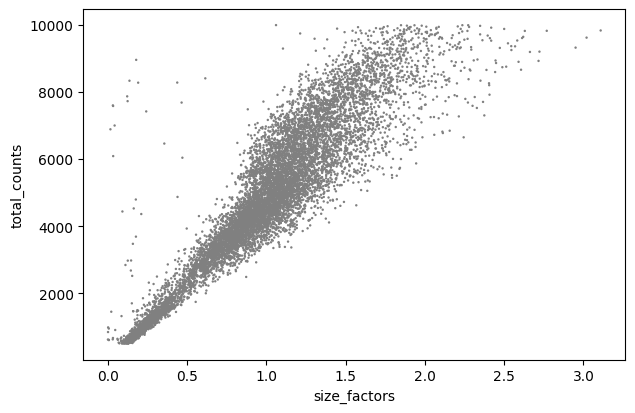

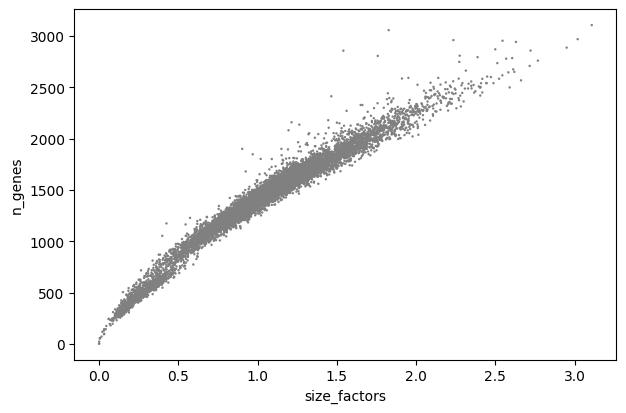

/var/folders/s5/3jq6kdq963b44s2lmrc_2fd40000gn/T/ipykernel_35077/1409471852.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(size_factors, bins=50, kde=False)


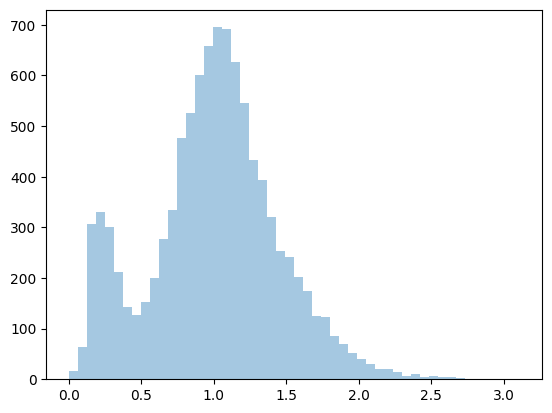

In [16]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'total_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [17]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [18]:
# high variable genes selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


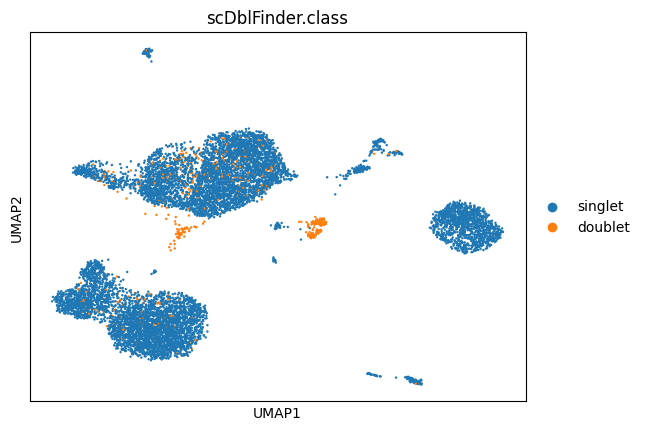

In [19]:
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.8)
sc.pl.umap(adata, color= ['scDblFinder.class'], save="_Slysz_fem_sample8_doublet.png", ncols=1)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


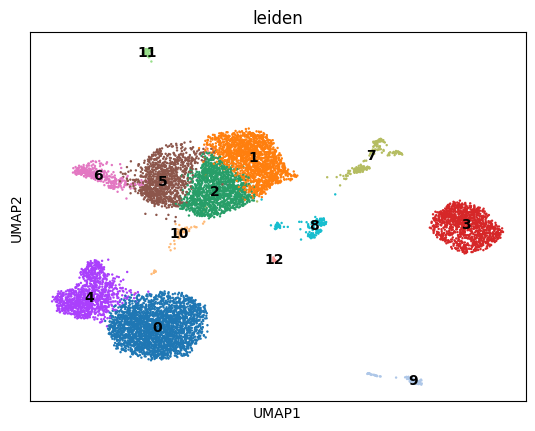

In [20]:
sc.pl.umap(adata, color= ['leiden'], save= "_Slysz_fem_sample8_leiden.png",ncols=1, legend_loc='on data')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


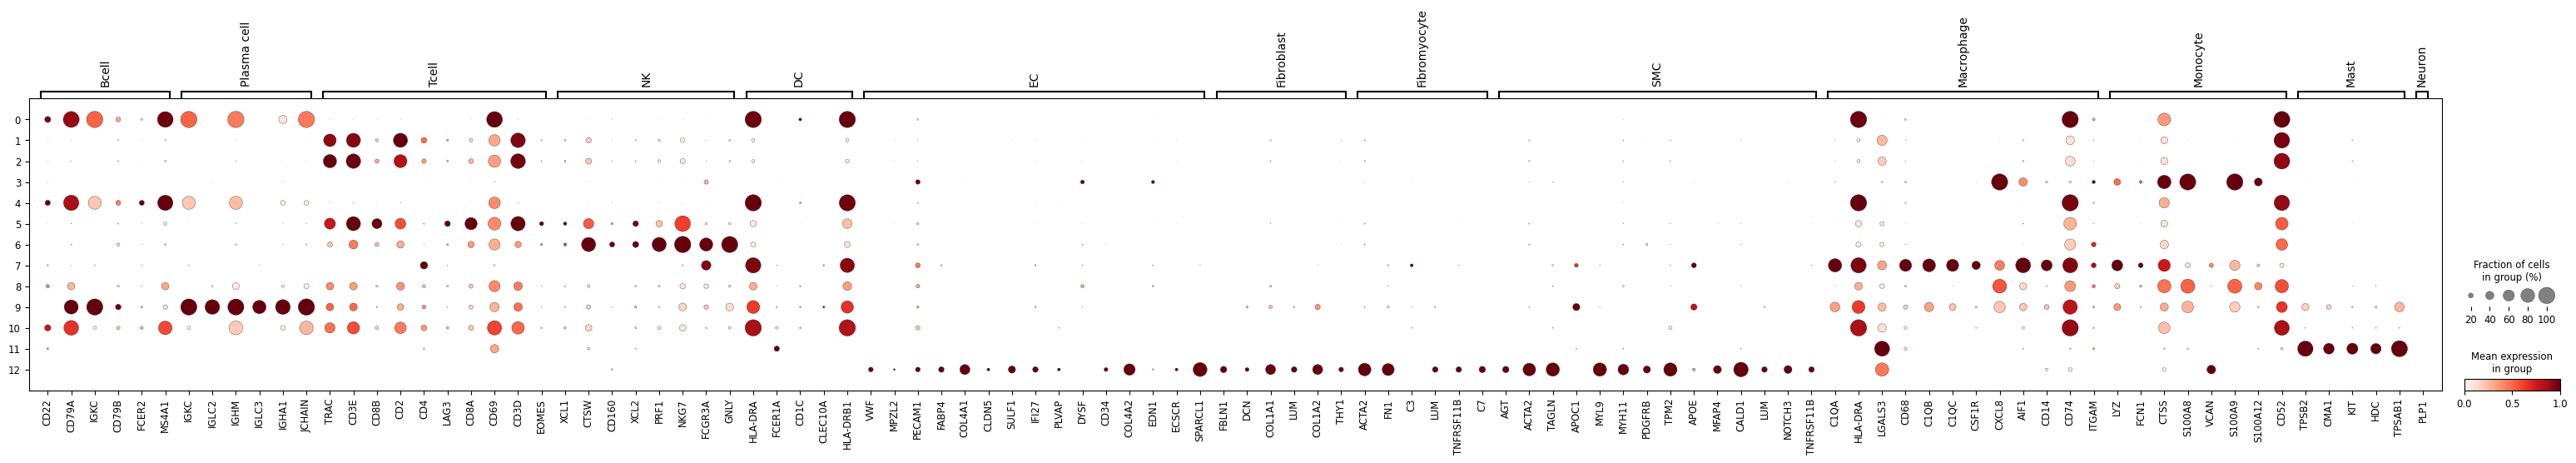

In [21]:
sc.pl.dotplot(
    adata,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="Slysz_fem_sample8.png"
)

In [22]:
cluster_annotation8 = {
    "0": "B cell",
    "1": "T cell",
    "2": "T cell",
    "3": "Monocyte",
    "4": "B cell",
    "5": "T cell",
    "6": "NK", 
    "7": "Macrophage",
    "8": "doublets", # REMOVE
    "9": "Plasma cell",
    "10": "doublets", # REMOVE
    "11": "Mast",
    "12": "unknown" # probably some Fibro stuff
}

In [23]:
adata.obs["cell_type_level1"] = adata.obs.leiden.map(cluster_annotation8)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


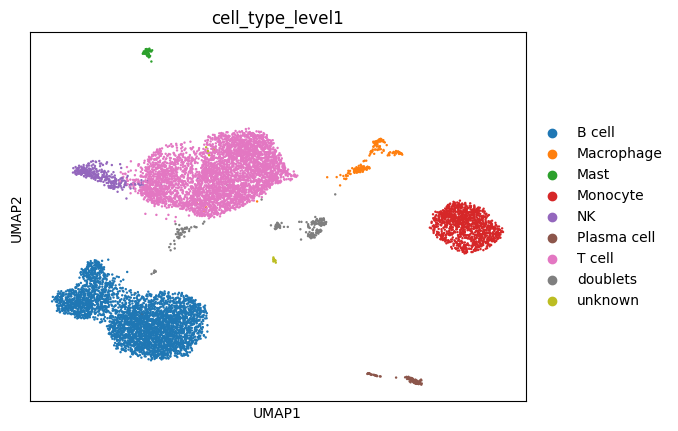

In [26]:
sc.pl.umap(adata, color= ['cell_type_level1'],ncols=1, save='_Slysz_fem_sample8_annot_with_doublets.png')

In [25]:
adata.write_h5ad("../data/Plaque-datasets/Slysz/Slysz_fem_sample8_annot.h5ad")

In [27]:
#delete all cells that have cell_type = doublets
adata = adata[adata.obs["cell_type_level1"] != "doublets", :].copy()

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


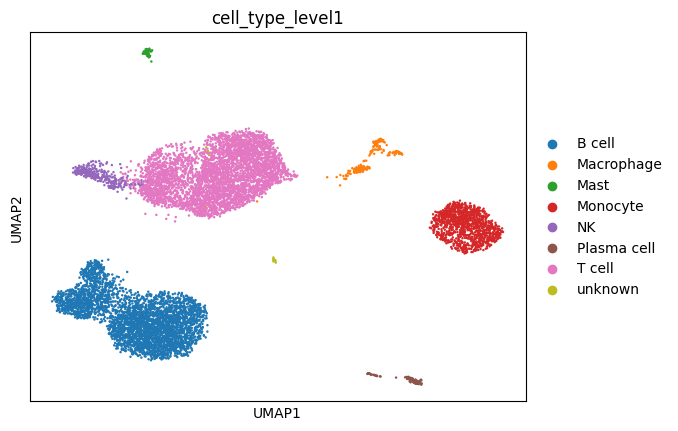

In [28]:
sc.pl.umap(adata, color= ['cell_type_level1'],ncols=1, save='_Slysz_fem_sample8_annot_no_doublets.png')

### Sample 6

In [9]:
adata = adata[adata.obs["sample"] == "6", :].copy() 

In [10]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/env

In [11]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [12]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.toarray()

In [13]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

Lade nötiges Paket: SingleCellExperiment
Lade nötiges Paket: SummarizedExperiment
Lade nötiges Paket: MatrixGenerics
Lade nötiges Paket: matrixStats

Attache Paket: ‘MatrixGenerics’

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQua

In [15]:
del adata_pp

In [16]:
#Normalize adata 
adata.obs['size_factors'] = size_factors
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [17]:
# high variable genes selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


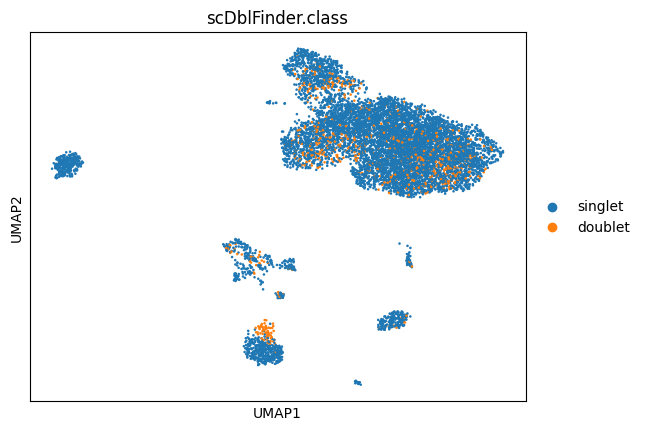

In [18]:
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.8)
sc.pl.umap(adata, color= ['scDblFinder.class'], ncols=1, save='_Slysz_fem_sample6_doublet.png')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


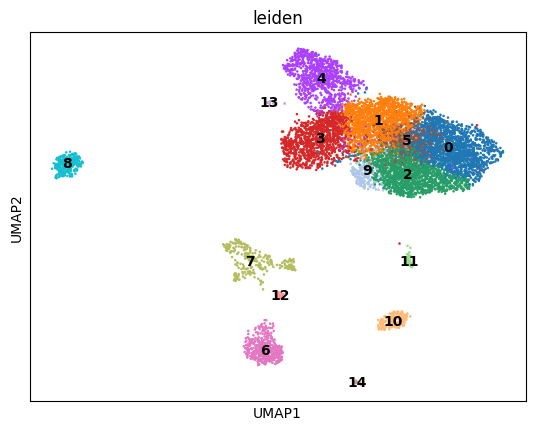

In [19]:
sc.pl.umap(adata, color= ['leiden'], save='_Slysz_fem_sample6_leiden.png', ncols=1, legend_loc='on data')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


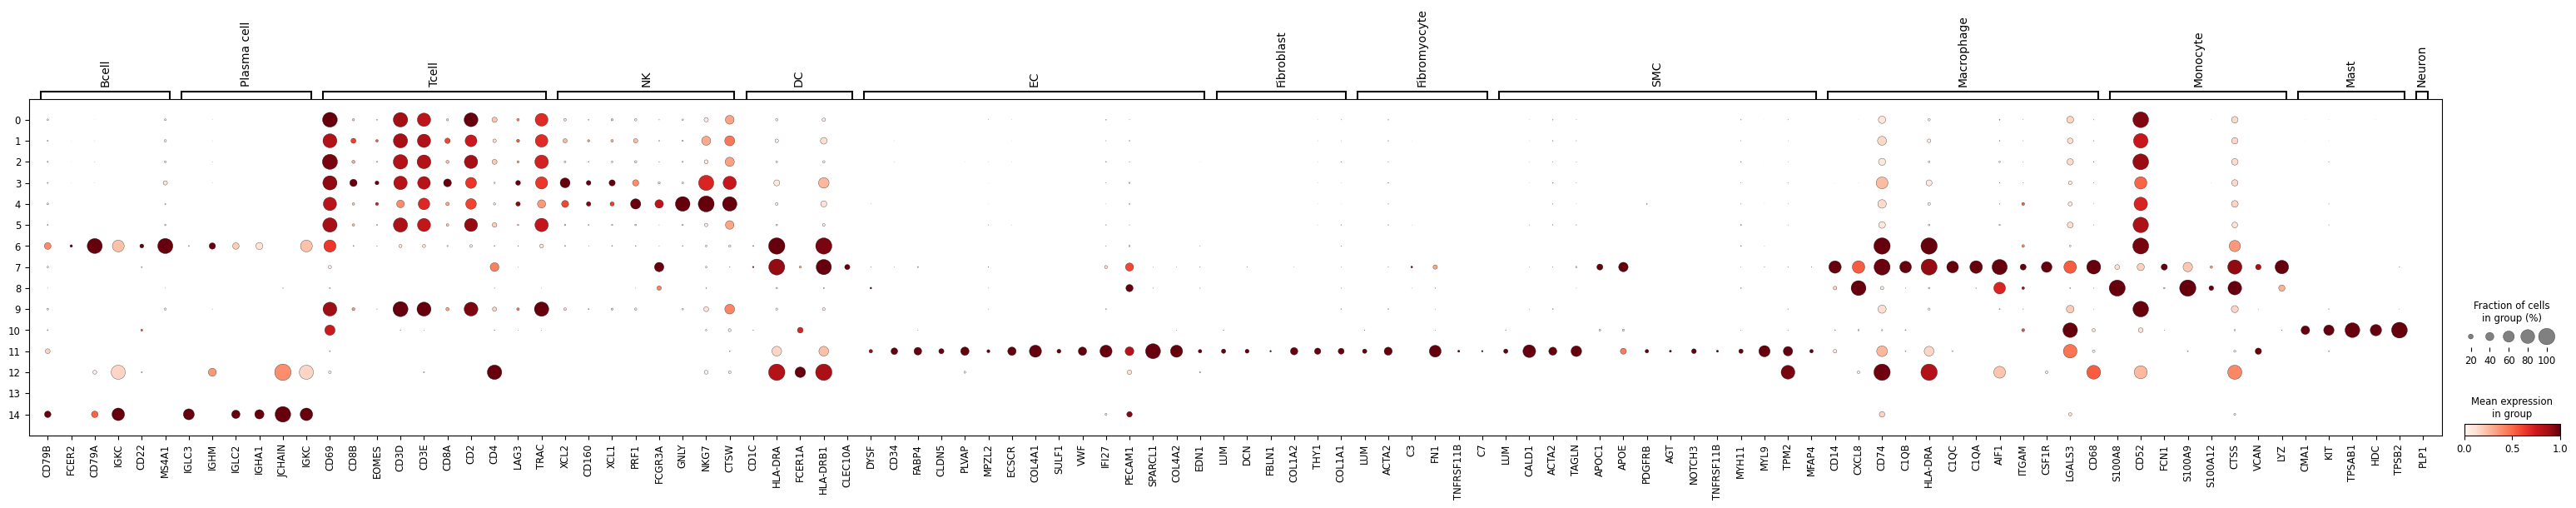

In [20]:
sc.pl.dotplot(
    adata,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="Slysz_fem_sample6.png",
)

In [21]:
cluster_annotation6 = {
    "0": "T cell",
    "1": "T cell",
    "2": "T cell",
    "3": "T cell",
    "4": "NK",
    "5": "T cell",
    "6": "B cell", 
    "7": "Macrophage",
    "8": "Monocytes", 
    "9": "T cell",
    "10": "Mast cell", 
    "11": "unknown",
    "12": "DC",
    "13": "unknown",
    "14": "Plasma cell"
}

In [22]:
adata.obs["cell_type_level1"] = adata.obs.leiden.map(cluster_annotation6)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


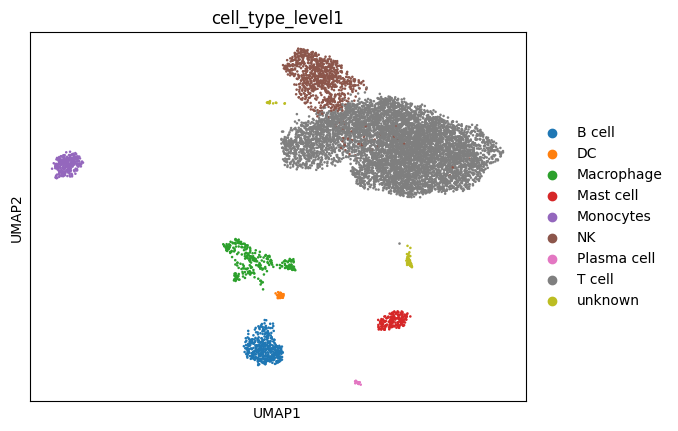

In [23]:
sc.pl.umap(adata, color= ['cell_type_level1'],ncols=1, save='_Slysz_fem_sample6_annot.png')

In [24]:
adata.write_h5ad("../data/Plaque-datasets/Slysz/Slysz_fem_sample6_annot.h5ad")

# Pan

In [3]:
adata = sc.read_h5ad("../data/Plaque-datasets/Pan/GSE155512_RAW/Pan_postQC.h5ad")

In [4]:
adata.layers['rounded_corrected_counts'] = adata.X.copy()

In [5]:
#check how many cells have zero counts for all genes
cellwise_sum = adata.X.sum(axis=1)
num_cells_zero_counts = (cellwise_sum == 0).sum()
#remove cells with zero counts for all genes
adata = adata[cellwise_sum != 0].copy()
print(num_cells_zero_counts)

0


In [6]:
adata.obs['sample'].value_counts()

sample
2    3486
3    2767
1    2614
Name: count, dtype: int64

In [7]:
#check if the marker genes are in the data and print percentage of marker genes per celltype in the data
#also print which marker genes are not in the data
#create new dict on the way
marker_genes_in_data = {}
for celltype in level1_marker:
    marker_genes_in_data[celltype] = list(set(level1_marker[celltype]).intersection(adata.var_names))
    print(celltype, len(set(level1_marker[celltype]).intersection(adata.var_names))/len(level1_marker[celltype]))
    print("not included: ", set(level1_marker[celltype]).difference(adata.var_names))

Bcell 1.0
not included:  set()
Plasma cell 1.0
not included:  set()
Tcell 1.0
not included:  set()
NK 1.0
not included:  set()
DC 1.0
not included:  set()
EC 1.0
not included:  set()
Fibroblast 1.0
not included:  set()
Fibromyocyte 1.0
not included:  set()
SMC 1.0
not included:  set()
Macrophage 1.0
not included:  set()
Monocyte 1.0
not included:  set()
Mast 1.0
not included:  set()
Neuron 1.0
not included:  set()


### Sample 2

In [8]:
adata = adata[adata.obs["sample"] == "2", :].copy() 

In [9]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/env

In [10]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [11]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.toarray()

In [12]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

Lade nötiges Paket: SingleCellExperiment
Lade nötiges Paket: SummarizedExperiment
Lade nötiges Paket: MatrixGenerics
Lade nötiges Paket: matrixStats

Attache Paket: ‘MatrixGenerics’

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQua

In [13]:
del adata_pp

In [14]:
#Normalize adata 
adata.obs['size_factors'] = size_factors
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [15]:
# high variable genes selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


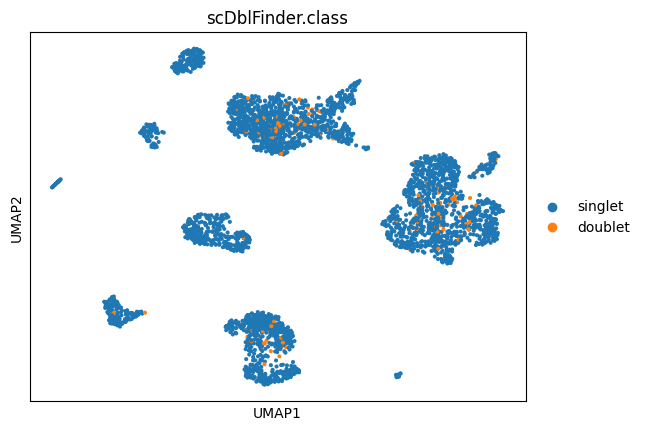

In [16]:
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.8)
sc.pl.umap(adata, color= ['scDblFinder.class'], ncols=1, save='_Pan_sample2_doublet.png')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


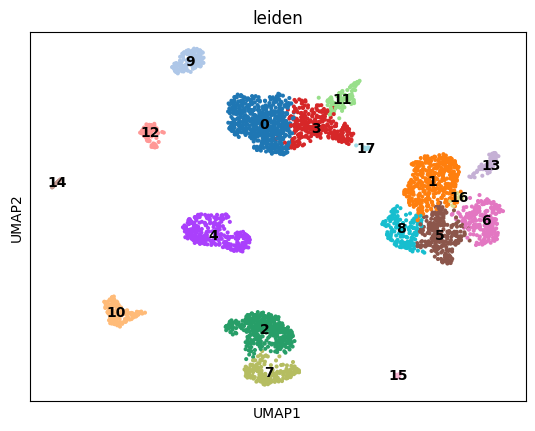

In [17]:
sc.pl.umap(adata, color= ['leiden'], save='_Pan_sample2_leiden.png', ncols=1, legend_loc='on data')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


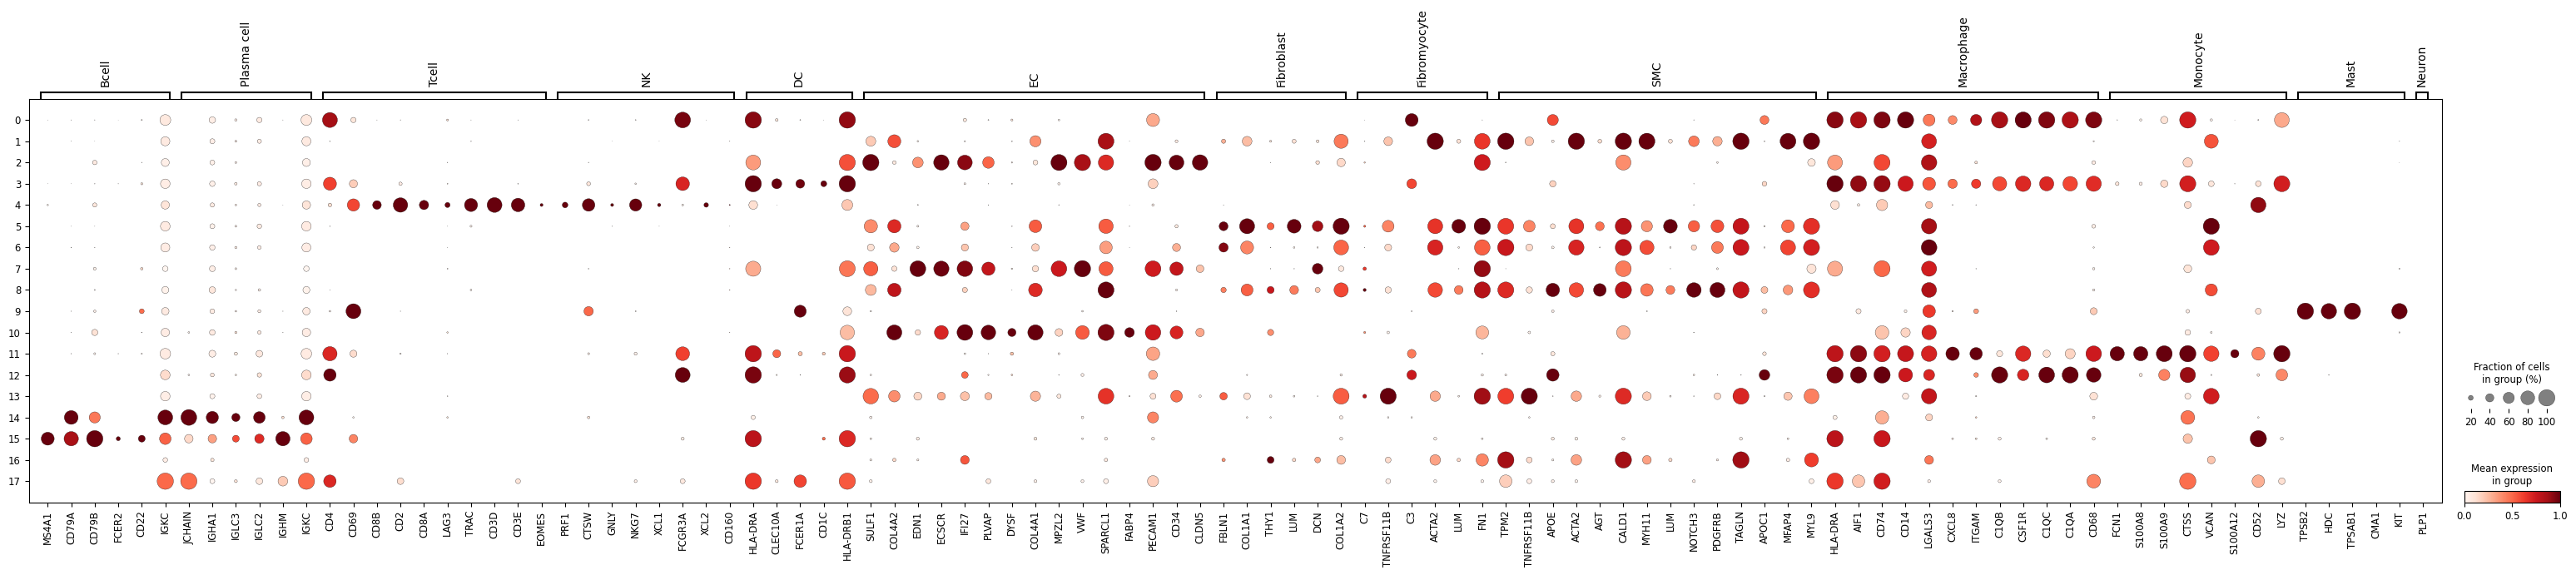

In [18]:
sc.pl.dotplot(
    adata,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="Pan_sample2.png",
)

In [20]:
cluster_annotation2 = {
    "0": "Macrophage",
    "1": "SMC",
    "2": "EC",
    "3": "DC",
    "4": "T cell",
    "5": "Fibroblast",
    "6": "unknown", 
    "7": "EC",
    "8": "SMC", # maybe also fibromyocyte 
    "9": "Mast cell",
    "10": "EC", 
    "11": "Monocyte",
    "12": "Macrophage",
    "13": "unknown",
    "14": "Plasma cell",
    "15": "B cell",
    "16": "unknown",
    "17": "unknown"
}

In [21]:
adata.obs["cell_type_level1"] = adata.obs.leiden.map(cluster_annotation2)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


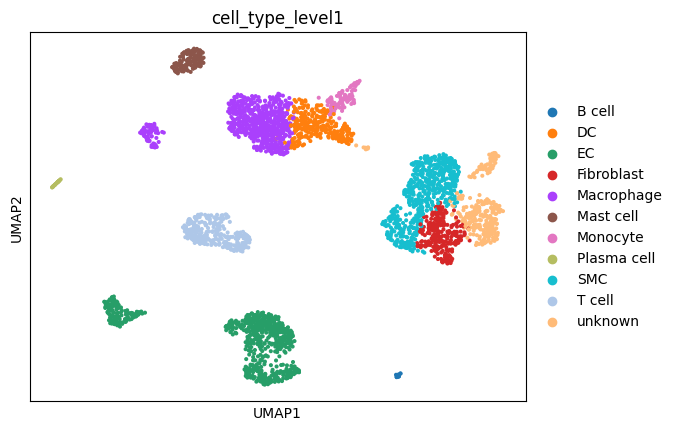

In [22]:
sc.pl.umap(adata, color= ['cell_type_level1'],ncols=1, save='_Pan_sample2_annot.png')

In [23]:
adata.write_h5ad("../data/Plaque-datasets/Pan/Pan_sample2_annot.h5ad")

### Sample3

In [8]:
adata = adata[adata.obs["sample"] == "3", :].copy() 

In [9]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/env

In [10]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [11]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.toarray()

In [12]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

Lade nötiges Paket: SingleCellExperiment
Lade nötiges Paket: SummarizedExperiment
Lade nötiges Paket: MatrixGenerics
Lade nötiges Paket: matrixStats

Attache Paket: ‘MatrixGenerics’

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQua

In [13]:
del adata_pp

In [14]:
#Normalize adata 
adata.obs['size_factors'] = size_factors
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [15]:
# high variable genes selection
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


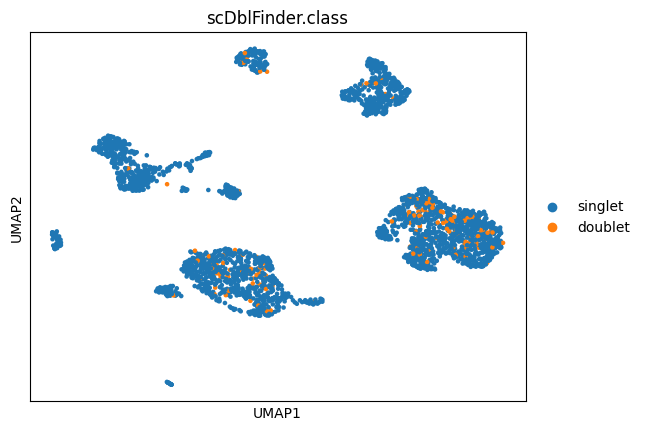

In [16]:
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.8)
sc.pl.umap(adata, color= ['scDblFinder.class'], ncols=1, save='_Pan_sample3_doublet.png')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


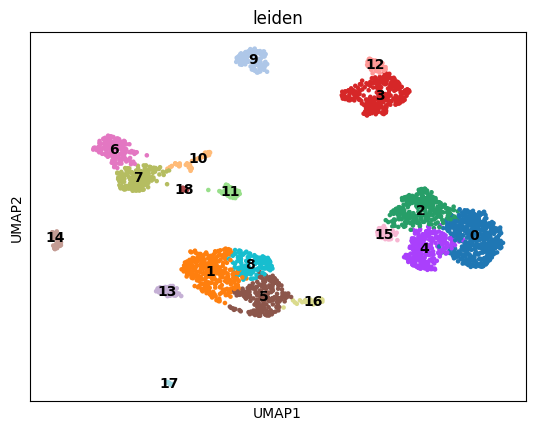

In [17]:
sc.pl.umap(adata, color= ['leiden'], save='_Pan_sample3_leiden.png', ncols=1, legend_loc='on data')

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


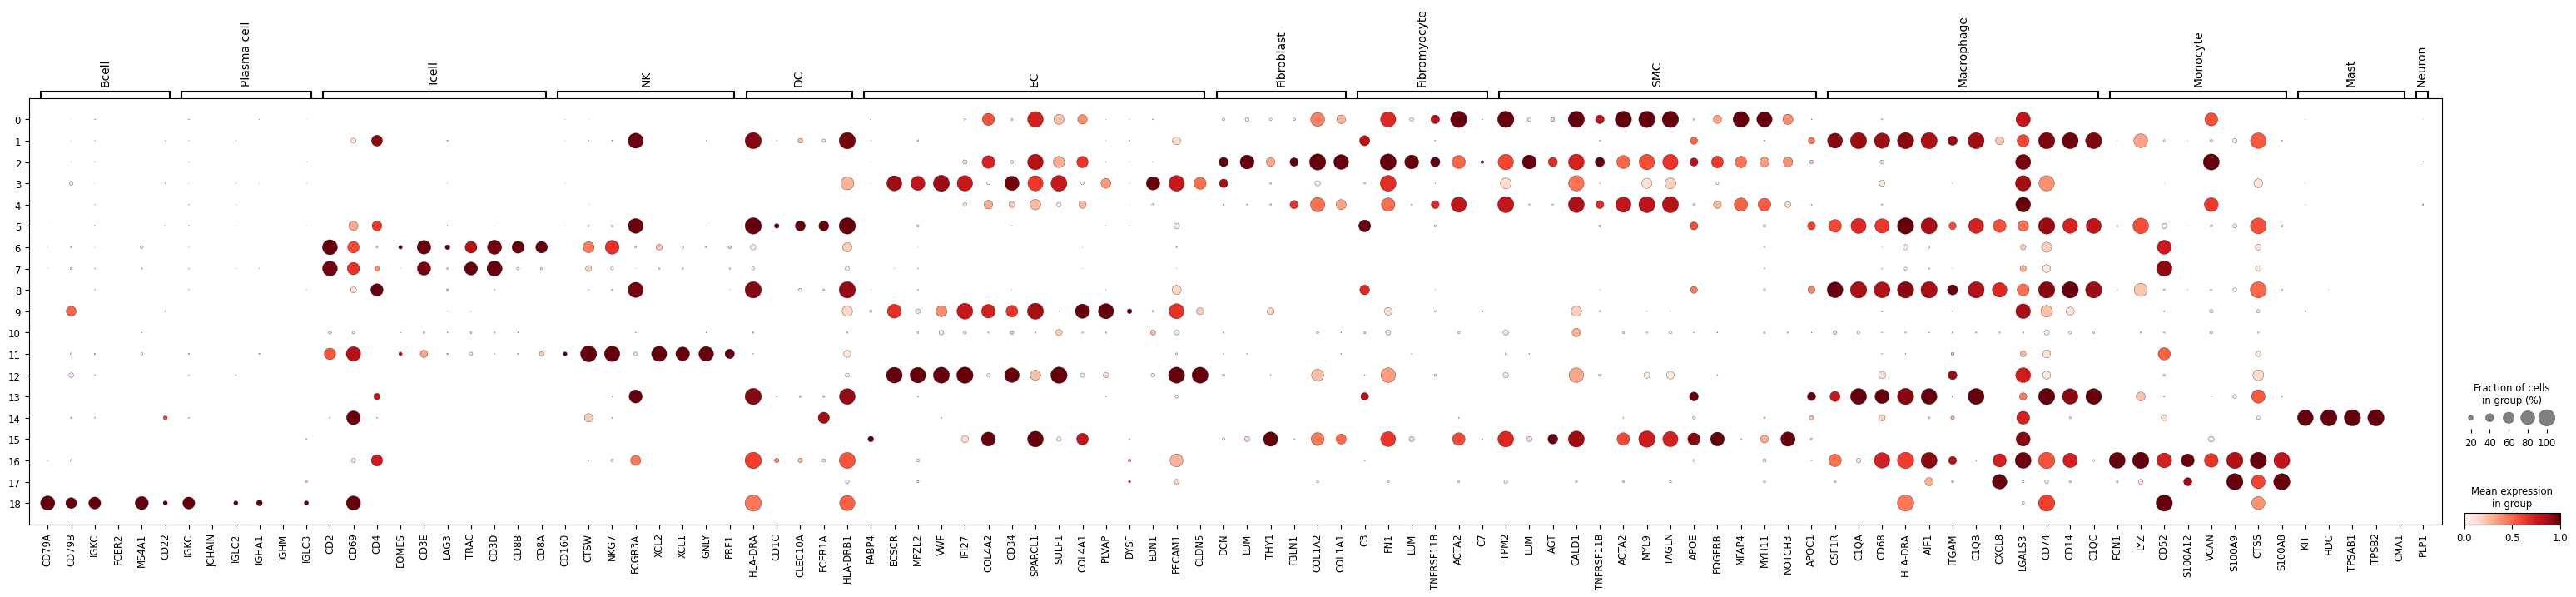

In [18]:
sc.pl.dotplot(
    adata,
    groupby="leiden",
    var_names=marker_genes_in_data,
    standard_scale="var",  # standard scale: normalize each gene to range from 0 to 1
    save="Pan_sample3.png",
)

In [19]:
cluster_annotation3 = {
    "0": "SMC",
    "1": "Macrophage",
    "2": "Fibromyocyte", # because of FN1 and some ACTA2
    "3": "EC",
    "4": "SMC",
    "5": "DC",
    "6": "T cell", 
    "7": "T cell",
    "8": "Macrophage", 
    "9": "EC",
    "10": "unknown", 
    "11": "NK",
    "12": "EC",
    "13": "Macrophage",
    "14": "Mast cell",
    "15": "unknown",
    "16": "Monocyte",
    "17": "unknown",
    "18": "B cell"
}

In [20]:
adata.obs["cell_type_level1"] = adata.obs.leiden.map(cluster_annotation3)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


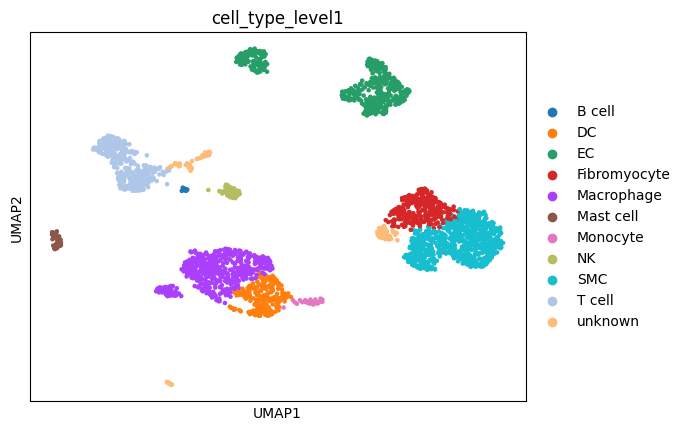

In [21]:
sc.pl.umap(adata, color= ['cell_type_level1'],ncols=1, save='_Pan_sample3_annot.png')

In [22]:
adata.write_h5ad("../data/Plaque-datasets/Pan/Pan_sample3_annot.h5ad")

# Pauli et al. (see comment)

Mapping annotations to our names. Cell types annotations only used later to validate predictions. not used in benchmark/small_integration

In [2]:
adata = sc.read_h5ad("../data/Plaque-datasets/Lars_Roche2/Roche_postQC.h5ad")

In [3]:
adata.obs

dataset            cell_type  n_genes_by_counts  \
car02_d_AAATGGATCGAGTGGA.1   Roche                CD8 T              647.0   
car02_d_AAGGAATGTCGTTGGC.1   Roche               Inf MΦ             2881.0   
car02_d_AATGGCTTCTTCCAGC.1   Roche             TREM2 MΦ             4906.0   
car02_d_ACCTACCGTTTACTGG.1   Roche          Plasma cell              335.0   
car02_d_ACCTGAAGTCATCCCT.1   Roche            Mast cell             1113.0   
...                            ...                  ...                ...   
car09_d_TTGTTTGCACGCTGTG.1   Roche                 EC A             1154.0   
car09_d_TTTACCAAGGCGTTGA.1   Roche                CD4 T              775.0   
car09_d_TTTACTGAGCGTGTCC.1   Roche  Proliferating cells             1422.0   
car09_d_TTTCAGTTCTCCACTG.1   Roche               Inf MΦ             1791.0   
car09_d_TTTCCTCGTTAACAGA.1   Roche  Proliferating cells              313.0   

                            total_counts  total_counts_mt  pct_counts_mt  \
car02_d_AAATGGATCGAGTGGA.1        1273.0             78.0       6.127258   
car02_d_AAGGAATGTCGTTGGC.1        9727.0           1564.0      16.078955   
car02_d_AATGGCTTCTTCCAGC.1       43494.0           3031.0       6.968777   
car02_d_ACCTACCGTTTACTGG.1        8015.0              3.0       0.037430   
car02_d_ACCTGAAGTCATCCCT.1        2843.0            219.0       7.703130   
...                                  ...              ...            ...   
car09_d_TTGTTTGCACGCTGTG.1        2085.0             55.0       2.637890   
car09_d_TTTACCAAGGCGTTGA.1        1641.0            132.0       8.043876   
car09_d_TTTACTGAGCGTGTCC.1       20991.0            217.0       1.033776   
car09_d_TTTCAGTTCTCCACTG.1        4758.0            123.0       2.585120   
car09_d_TTTCCTCGTTAACAGA.1       23605.0             17.0       0.072019   

                           sample scDblFinder.sample scDblFinder.class  \
car02_d_AAATGGATCGAGTGGA.1      2                  2           singlet   
car02_d_AAGGAATGTCGTTGGC.1      2                  2           singlet   
car02_d_AATGGCTTCTTCCAGC.1      2                  2           doublet   
car02_d_ACCTACCGTTTACTGG.1      2                  2           singlet   
car02_d_ACCTGAAGTCATCCCT.1      2                  2           singlet   
...                           ...                ...               ...   
car09_d_TTGTTTGCACGCTGTG.1      9                  9           singlet   
car09_d_TTTACCAAGGCGTTGA.1      9                  9           singlet   
car09_d_TTTACTGAGCGTGTCC.1      9                  9           singlet   
car09_d_TTTCAGTTCTCCACTG.1      9                  9           singlet   
car09_d_TTTCCTCGTTAACAGA.1      9                  9           singlet   

                            scDblFinder.score  scDblFinder.weighted  \
car02_d_AAATGGATCGAGTGGA.1           0.507475              1.000000   
car02_d_AAGGAATGTCGTTGGC.1           0.563011              1.000000   
car02_d_AATGGCTTCTTCCAGC.1           0.675130              0.973690   
car02_d_ACCTACCGTTTACTGG.1           0.501177              1.000000   
car02_d_ACCTGAAGTCATCCCT.1           0.520772              1.000000   
...                                       ...                   ...   
car09_d_TTGTTTGCACGCTGTG.1           0.439140              0.958970   
car09_d_TTTACCAAGGCGTTGA.1           0.106232              0.907362   
car09_d_TTTACTGAGCGTGTCC.1           0.473998              0.917750   
car09_d_TTTCAGTTCTCCACTG.1           0.600202              0.942284   
car09_d_TTTCCTCGTTAACAGA.1           0.050025              0.473949   

                            scDblFinder.cxds_score  decontX_contamination  \
car02_d_AAATGGATCGAGTGGA.1                0.014949               0.000529   
car02_d_AAGGAATGTCGTTGGC.1                0.126022               0.024352   
car02_d_AATGGCTTCTTCCAGC.1                0.390259               0.000323   
car02_d_ACCTACCGTTTACTGG.1                0.002354               0.000003   
car02_d_ACCTGAAGTCATCCCT.1                0.041544

In [4]:
adata.obs["cell_type"].value_counts()

cell_type
Fibromyocyte           165
EC A                   147
CD4 T                  147
CD8 T                  145
non-MΦ Myeloid         108
NK                      77
VSMC B                  72
TREM2 MΦ                72
VSMC A                  72
Inf MΦ                  62
EC B                    60
Res MΦ                  40
Fibroblast              30
Proliferating cells     28
Plasma cell             24
Mast cell               18
B cell                  12
Name: count, dtype: int64

In [5]:
mapping_dict = {
    "T cell": ["CD4 T", "CD8 T"],
    "B cell": ["B cell"],
    "Fibroblast": ["Fibroblast"],
    "Fibromyocyte": ["Fibromyocyte"],
    "EC": ["EC A", "EC B"],
    "Macrophage": ["TREM2 MΦ", "Inf MΦ", "Res MΦ"],
    "NK": ["NK"],
    "SMC": ["VSMC A", "VSMC B"],
    "Mast cell": ["Mast cell"],
    "Plasma cell": ["Plasma cell"],
    "unknown": ["non-MΦ Myeloid", "Proliferating cells" ]
}

In [6]:
# add new obs called cell_type_level1. use the mapping dict to map the cell_type to cell_type_level1. The keys are the cell_type_level1 and the values are tuples with the cell_type that should be mapped to the cell_type_level1
adata.obs["cell_type_level1"] = adata.obs["cell_type"].map(lambda x: [k for k, v in mapping_dict.items() if x in v][0])

In [7]:
adata.obs

dataset            cell_type  n_genes_by_counts  \
car02_d_AAATGGATCGAGTGGA.1   Roche                CD8 T              647.0   
car02_d_AAGGAATGTCGTTGGC.1   Roche               Inf MΦ             2881.0   
car02_d_AATGGCTTCTTCCAGC.1   Roche             TREM2 MΦ             4906.0   
car02_d_ACCTACCGTTTACTGG.1   Roche          Plasma cell              335.0   
car02_d_ACCTGAAGTCATCCCT.1   Roche            Mast cell             1113.0   
...                            ...                  ...                ...   
car09_d_TTGTTTGCACGCTGTG.1   Roche                 EC A             1154.0   
car09_d_TTTACCAAGGCGTTGA.1   Roche                CD4 T              775.0   
car09_d_TTTACTGAGCGTGTCC.1   Roche  Proliferating cells             1422.0   
car09_d_TTTCAGTTCTCCACTG.1   Roche               Inf MΦ             1791.0   
car09_d_TTTCCTCGTTAACAGA.1   Roche  Proliferating cells              313.0   

                            total_counts  total_counts_mt  pct_counts_mt  \
car02_d_AAATGGATCGAGTGGA.1        1273.0             78.0       6.127258   
car02_d_AAGGAATGTCGTTGGC.1        9727.0           1564.0      16.078955   
car02_d_AATGGCTTCTTCCAGC.1       43494.0           3031.0       6.968777   
car02_d_ACCTACCGTTTACTGG.1        8015.0              3.0       0.037430   
car02_d_ACCTGAAGTCATCCCT.1        2843.0            219.0       7.703130   
...                                  ...              ...            ...   
car09_d_TTGTTTGCACGCTGTG.1        2085.0             55.0       2.637890   
car09_d_TTTACCAAGGCGTTGA.1        1641.0            132.0       8.043876   
car09_d_TTTACTGAGCGTGTCC.1       20991.0            217.0       1.033776   
car09_d_TTTCAGTTCTCCACTG.1        4758.0            123.0       2.585120   
car09_d_TTTCCTCGTTAACAGA.1       23605.0             17.0       0.072019   

                           sample scDblFinder.sample scDblFinder.class  \
car02_d_AAATGGATCGAGTGGA.1      2                  2           singlet   
car02_d_AAGGAATGTCGTTGGC.1      2                  2           singlet   
car02_d_AATGGCTTCTTCCAGC.1      2                  2           doublet   
car02_d_ACCTACCGTTTACTGG.1      2                  2           singlet   
car02_d_ACCTGAAGTCATCCCT.1      2                  2           singlet   
...                           ...                ...               ...   
car09_d_TTGTTTGCACGCTGTG.1      9                  9           singlet   
car09_d_TTTACCAAGGCGTTGA.1      9                  9           singlet   
car09_d_TTTACTGAGCGTGTCC.1      9                  9           singlet   
car09_d_TTTCAGTTCTCCACTG.1      9                  9           singlet   
car09_d_TTTCCTCGTTAACAGA.1      9                  9           singlet   

                            scDblFinder.score  scDblFinder.weighted  \
car02_d_AAATGGATCGAGTGGA.1           0.507475              1.000000   
car02_d_AAGGAATGTCGTTGGC.1           0.563011              1.000000   
car02_d_AATGGCTTCTTCCAGC.1           0.675130              0.973690   
car02_d_ACCTACCGTTTACTGG.1           0.501177              1.000000   
car02_d_ACCTGAAGTCATCCCT.1           0.520772              1.000000   
...                                       ...                   ...   
car09_d_TTGTTTGCACGCTGTG.1           0.439140              0.958970   
car09_d_TTTACCAAGGCGTTGA.1           0.106232              0.907362   
car09_d_TTTACTGAGCGTGTCC.1           0.473998              0.917750   
car09_d_TTTCAGTTCTCCACTG.1           0.600202              0.942284   
car09_d_TTTCCTCGTTAACAGA.1           0.050025              0.473949   

                            scDblFinder.cxds_score  decontX_contamination  \
car02_d_AAATGGATCGAGTGGA.1                0.014949               0.000529   
car02_d_AAGGAATGTCGTTGGC.1                0.126022               0.024352   
car02_d_AATGGCTTCTTCCAGC.1                0.390259               0.000323   
car02_d_ACCTACCGTTTACTGG.1                0.002354               0.000003   
car02_d_ACCTGAAGTCATCCCT.1                0.041544

In [8]:
adata.layers['rounded_corrected_counts'] = adata.X.copy()

In [9]:
#check how many cells have zero counts for all genes
cellwise_sum = adata.X.sum(axis=1)
num_cells_zero_counts = (cellwise_sum == 0).sum()
#remove cells with zero counts for all genes
adata = adata[cellwise_sum != 0].copy()

In [10]:
num_cells_zero_counts

1

In [11]:
adata.write_h5ad("../data/Plaque-datasets/Lars_Roche2/Roche_annot.h5ad")

In [2]:
# forgot to scran normalize + log1p .X before, so do it now

In [3]:
adata = sc.read_h5ad("../data/Plaque-datasets/Lars_Roche2/Roche_annot.h5ad")

In [4]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, svd_solver="arpack")
sc.pp.neighbors(adata_pp, n_pcs=30)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.22)

/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/envs/py39main/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/korbinian.traeuble/miniconda3/env

In [5]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [6]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T.toarray()

In [7]:
%%R -i data_mat -i input_groups -o size_factors
library(scran)
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

Lade nötiges Paket: SingleCellExperiment
Lade nötiges Paket: SummarizedExperiment
Lade nötiges Paket: MatrixGenerics
Lade nötiges Paket: matrixStats

Attache Paket: ‘MatrixGenerics’

Die folgenden Objekte sind maskiert von ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQua

In [8]:
del adata_pp

In [9]:
#Normalize adata 
adata.obs['size_factors'] = size_factors
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)

In [10]:
adata.X.sum()

2102677.1743558617

In [11]:
adata.write_h5ad("../data/Plaque-datasets/Lars_Roche2/Roche_annot.h5ad")